# Momentum Strategy Analysis – MTUM ETF
Full analysis of iShares MSCI USA Momentum ETF using historical data, statistical tests, machine learning, and time series models.

In [ ]:
!pip install arch
!pip install seaborn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.3/985.3 kB 17.8 MB/s eta 0:00:00


In [ ]:
# --- Data Analysis and Visualization Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- Financial Data ---
import yfinance as yf

# --- Statistical Analysis ---
from scipy import stats
from scipy.stats import linregress, ttest_ind, shapiro, mannwhitneyu
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.stattools import jarque_bera

# --- Machine Learning ---
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# --- Deep Learning ---
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

# --- Time Series Analysis ---
from arch import arch_model

# --- Visualization Configuration ---
import matplotlib.ticker as mtick
import matplotlib.dates as mdates

# --- Advanced ML Models ---
from xgboost import XGBRegressor

In [ ]:
# Download historical price data for the MTUM ETF from Yahoo Finance (2013–2025)
mtum = yf.download('MTUM', start='2012-01-01', end='2025-04-16')

# Calculate daily simple returns (percentage change from the previous day)
mtum['Return'] = mtum['Close'].pct_change()

# Calculate log returns (percentage change from the previous day)
mtum['Log_Return'] = np.log(mtum['Close'] / mtum['Close'].shift(1))

# Drop rows with missing values (due to lagged percentage change calculations)
mtum.dropna(inplace=True)

# Extract the year from the datetime index and store it in a new column
mtum['Year'] = mtum.index.year

# Display
mtum

YF.download() has changed argument auto_adjust default to True


ERROR:yfinance:Failed to get ticker 'MTUM' reason: HTTPSConnectionPool(host='query2.finance.yahoo.com', port=443): Read timed out. (read timeout=10)
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume,Return,Log_Return,Year
Ticker,MTUM,MTUM,MTUM,MTUM,MTUM,,,
Date,,,,,,,,
2013-04-19,43.993671,43.993671,43.993671,43.993671,0,0.000000,0.000000,2013
2013-04-22,43.993671,43.993671,43.993671,43.993671,0,0.000000,0.000000,2013
2013-04-23,45.116859,45.116859,45.116859,45.116859,600,0.025531,0.025210,2013
2013-04-24,44.546627,44.667583,44.546627,44.667583,1100,-0.012639,-0.012720,2013
2013-04-25,44.762615,44.762615,44.762615,44.762615,400,0.004849,0.004837,2013
...,...,...,...,...,...,...,...,...
2025-04-09,199.789993,201.460007,179.039993,180.149994,1825600,0.104789,0.099654,2025
2025-04-10,193.259995,196.820007,187.539993,195.929993,1009500,-0.032684,-0.033230,2025


In [ ]:
# Create a separate DataFrame for rolling momentum metrics
momentum_metrics = pd.DataFrame(index=mtum.index)
momentum_metrics['Rolling_Momentum_6M'] = mtum['Close'].pct_change(periods=126)
momentum_metrics['Rolling_Momentum_12M'] = mtum['Close'].pct_change(periods=252)

# Drop rows with NaNs in the momentum metrics dataset only
momentum_metrics.dropna(inplace=True)

# Display
momentum_metrics


,Rolling_Momentum_6M,Rolling_Momentum_12M
Date,,
2014-04-21,0.074490,0.193472
2014-04-22,0.077506,0.203219
2014-04-23,0.076371,0.167252
2014-04-24,0.059606,0.178068
2014-04-25,0.044521,0.152443
...,...,...
2025-04-09,-0.008976,0.075032
2025-04-10,-0.050798,0.046495
2025-04-11,-0.044714,0.065900


##Cumulative Return

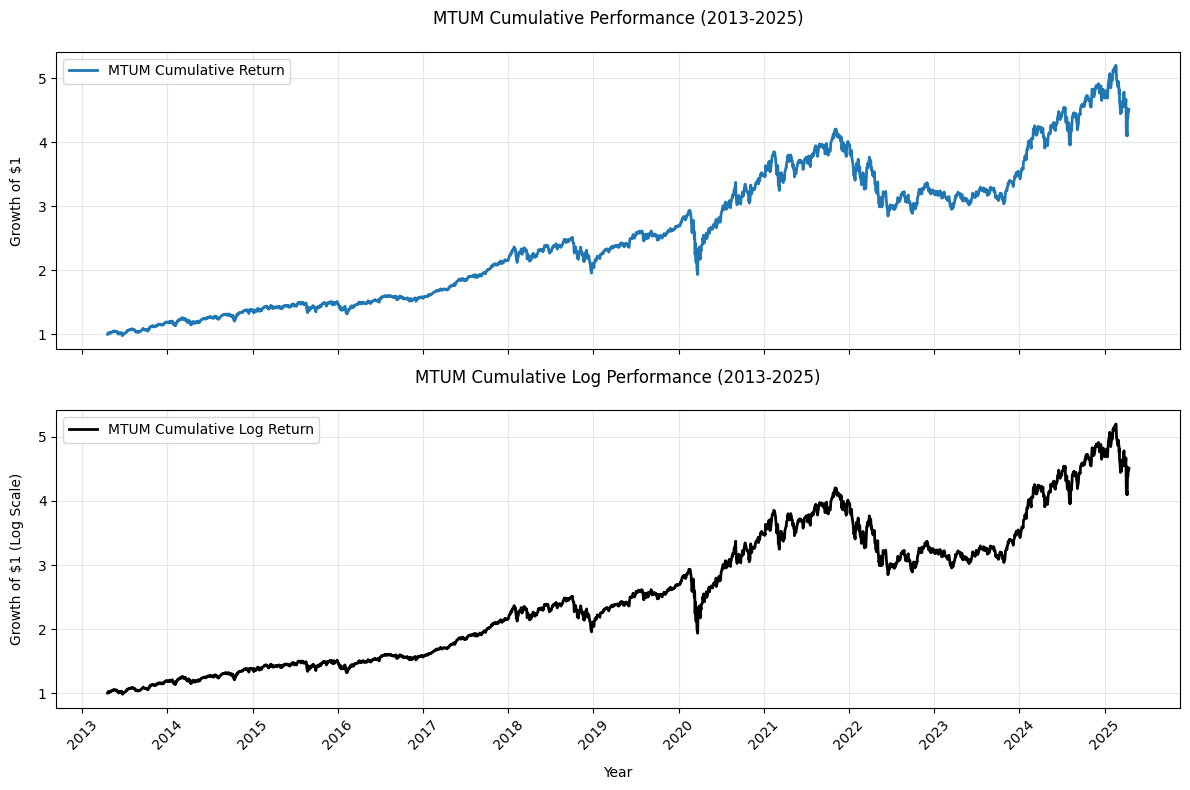

In [ ]:
# Calculate cumulative metrics
mtum['Cumulative'] = (1 + mtum['Return']).cumprod()
mtum['Cumulative_Log'] = np.exp(mtum['Log_Return'].cumsum())

# Drop any remaining NaNs (shouldn't be necessary if previous steps were completed)
mtum.dropna(inplace=True)

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Plot 1: Simple Returns Cumulative Performance
ax1.plot(mtum.index, mtum['Cumulative'],
         label='MTUM Cumulative Return',
         color='#1f77b4',
         linewidth=2)
ax1.set_title('MTUM Cumulative Performance (2013-2025)', pad=20)
ax1.set_ylabel('Growth of $1', labelpad=10)
ax1.grid(True, alpha=0.3)
ax1.legend(loc='upper left')

# Plot 2: Log Returns Cumulative Performance
ax2.plot(mtum.index, mtum['Cumulative_Log'],
         label='MTUM Cumulative Log Return',
         color='black',
         linewidth=2)
ax2.set_title('MTUM Cumulative Log Performance (2013-2025)', pad=20)
ax2.set_xlabel('Year', labelpad=10)
ax2.set_ylabel('Growth of $1 (Log Scale)', labelpad=10)
ax2.grid(True, alpha=0.3)
ax2.legend(loc='upper left')

# Format x-axis for both plots
for ax in [ax1, ax2]:
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## Descriptive statistics

In [ ]:
# =============================================
# STYLE SETUP
# =============================================

custom_style = [
    {'selector': 'table',
     'props': [
         ('border', 'none'),
         ('background-color', '#243673'),
         ('color', 'white'),
         ('width', '100%'),
         ('border-collapse', 'collapse'),
         ('font-family', 'Roboto, sans-serif'),
         ('table-layout', 'fixed')
     ]},

    {'selector': 'th, td',
     'props': [
         ('padding', '8px 12px'),
         ('text-align', 'center'),
         ('color', 'white'),
         ('font-weight', 'bold'),
         ('font-family', 'Roboto, sans-serif')
     ]},

    {'selector': 'tr',
     'props': [('background-color', '#243673')]},

    {'selector': 'th',
     'props': [
         ('border-bottom', '2px solid white'),
         ('font-size', '14px'),
         ('text-align', 'center')
     ]},

    {'selector': 'caption',
     'props': [
         ('color', 'white'),
         ('font-size', '16px'),
         ('font-weight', 'bold'),
         ('margin-bottom', '12px'),
         ('text-align', 'center')
     ]},

    {'selector': 'td:nth-child(2), th:nth-child(2)',
     'props': [('border-left', '3px solid white')]},

    {'selector': 'tr td',
     'props': [('border-bottom', '2px solid white')]}
]

def percentage_format(x):
    """Format values as percentages with 2 decimal places"""
    if isinstance(x, (int, float)):
        return '{:,.2f}%'.format(x) if abs(x) < 1000 else '{:,.0f}%'.format(x)
    return x

def create_clean_table(data_dict, title):
    """
    Create a styled table for a specific stats section
    """
    df = pd.DataFrame.from_dict(data_dict, orient='index', columns=['Value'])
    df.reset_index(inplace=True)
    df.columns = ['Metric', 'Value']

    return (df.style
              .format({'Value': percentage_format})
              .set_table_styles(custom_style)
              .set_caption(title)
              .hide(axis='index')
              .set_table_attributes('style="width:100%; table-layout:fixed;"'))

def match_column_widths(ref_styler, target_styler):
    """
    Apply the same column widths from ref_styler to target_styler.
    Assumes 2 columns: Metric (70%), Value (30%)
    """
    return (target_styler
            .set_table_attributes('style="width:100%; table-layout:fixed;"')
            .set_table_styles(custom_style)
            .set_properties(subset=['Metric'], **{'width': '70%', 'text-align': 'left'})
            .set_properties(subset=['Value'], **{'width': '30%', 'text-align': 'center'}))

# =============================================
# CALCULATE EXTENDED STATISTICS
# =============================================

downside_returns = mtum['Return'][mtum['Return'] < 0]
downside_std = downside_returns.std()
sortino_ratio = (mtum['Return'].mean() / downside_std) * np.sqrt(252) if downside_std > 0 else np.nan

max_runup = (mtum['Cumulative'] / mtum['Cumulative'].cummin() - 1).max() * 100
VaR_1d = np.percentile(mtum['Return'], 1) * 100
CVaR_1d = mtum['Return'][mtum['Return'] <= np.percentile(mtum['Return'], 1)].mean() * 100

# =============================================
# CREATE STATISTICS DICTIONARIES
# =============================================

return_risk_stats = {
    "Mean Daily Return": mtum['Return'].mean() * 100,
    "Standard Deviation (Daily)": mtum['Return'].std() * 100,
    "Annualized Return (Simple)": ((1 + mtum['Return'].mean())**252 - 1) * 100,
    "Annualized Volatility": mtum['Return'].std() * np.sqrt(252) * 100,
    "Sharpe Ratio (Annualized, Rf=0)": (mtum['Return'].mean() / mtum['Return'].std()) * np.sqrt(252),
    "Sortino Ratio (Annualized)": sortino_ratio,
    "Skewness": mtum['Return'].skew(),
    "Kurtosis": mtum['Return'].kurt()
}

performance_metrics = {
    "Maximum Drawdown": (mtum['Cumulative'] / mtum['Cumulative'].cummax() - 1).min() * 100,
    "Maximum Run-up": max_runup,
    "Total Return (Since Injection)": (mtum['Cumulative'].iloc[-1] - 1) * 100
}

momentum_stats = {
    "Average Momentum 6M": momentum_metrics['Rolling_Momentum_6M'].mean() * 100,
    "Std Dev Momentum 6M": momentum_metrics['Rolling_Momentum_6M'].std() * 100,
    "Positive Momentum 6M (%)": (momentum_metrics['Rolling_Momentum_6M'] > 0).mean() * 100,
    "Maximum Momentum 6M": momentum_metrics['Rolling_Momentum_6M'].max() * 100,
    "Minimum Momentum 6M": momentum_metrics['Rolling_Momentum_6M'].min() * 100,
}

risk_metrics = {
    "VaR(1%) - Daily": VaR_1d,
    "CVaR - Daily": CVaR_1d
}

# =============================================
# CREATE & DISPLAY SYNCHRONIZED TABLES
# =============================================

# Step 1 – Create all tables
table1 = create_clean_table(return_risk_stats, "Return & Risk Statistics")
table2 = create_clean_table(performance_metrics, "Performance Metrics")
table3 = create_clean_table(momentum_stats, "Momentum Statistics")
table4 = create_clean_table(risk_metrics, "Risk Metrics")

# Step 2 – Match widths to table1
table2 = match_column_widths(table1, table2)
table3 = match_column_widths(table1, table3)
table4 = match_column_widths(table1, table4)

# Step 3 – Display all
display(table1)
print("\n")
display(table2)
print("\n")
display(table3)
print("\n")
display(table4)

Metric,Value
Mean Daily Return,0.06%
Standard Deviation (Daily),1.24%
Annualized Return (Simple),15.63%
Annualized Volatility,19.70%
"Sharpe Ratio (Annualized, Rf=0)",0.74%
Sortino Ratio (Annualized),0.91%
Skewness,-0.30%
Kurtosis,10.99%


Metric,Value
Maximum Drawdown,-34.08%
Maximum Run-up,428.58%
Total Return (Since Injection),350.94%


Metric,Value
Average Momentum 6M,7.13%
Std Dev Momentum 6M,10.76%
Positive Momentum 6M (%),81.16%
Maximum Momentum 6M,60.00%
Minimum Momentum 6M,-27.64%


Metric,Value
VaR(1%) - Daily,-3.71%
CVaR - Daily,-4.94%


## Annual Return & Rolling Sharpe Ratio

In [ ]:
# Download daily MTUM data for the year 2014
mtum_2014 = yf.download('MTUM', start='2014-01-01', end='2015-01-01')

# Count trading days (DataFrame rows)
print("/n" )
print(f"Trading days in 2014: {len(mtum_2014)}")

[*********************100%***********************]  1 of 1 completed

/n
Trading days in 2014: 252


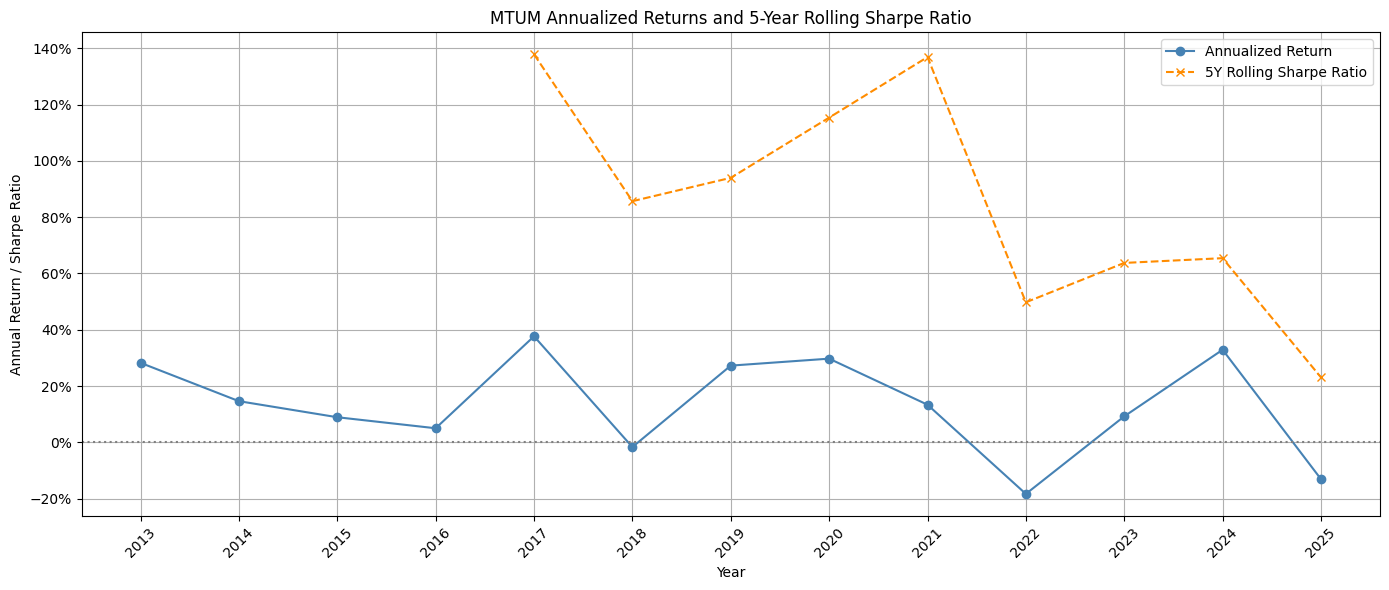

In [ ]:
# Annualized return using actual number of trading days per year
def annualized_return(series):
    n_days = series.count()  # Count of trading days in the year
    cumulative = (1 + series).prod() - 1  # Cumulative return over the year
    return (1 + cumulative) ** (252 / n_days) - 1  # Annualized return adjustment

# Calculate annualized returns per year
annual_returns = mtum['Return'].groupby(mtum['Year']).agg(annualized_return)

# Compute 5-year rolling Sharpe ratio
rolling_sharpe = annual_returns.rolling(window=5).apply(lambda x: x.mean() / x.std()).dropna()

# Plot both on the same chart
plt.figure(figsize=(14, 6))
plt.plot(annual_returns.index, annual_returns.values, label='Annualized Return', color='steelblue', marker='o')
plt.plot(rolling_sharpe.index, rolling_sharpe.values, label='5Y Rolling Sharpe Ratio', color='darkorange', linestyle='--', marker='x')

# Format x-axis and y-axis
plt.xticks(ticks=annual_returns.index, rotation=45)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

# Labels and formatting
plt.title('MTUM Annualized Returns and 5-Year Rolling Sharpe Ratio')
plt.xlabel('Year')
plt.ylabel('Annual Return / Sharpe Ratio')
plt.axhline(0, color='gray', linestyle=':')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

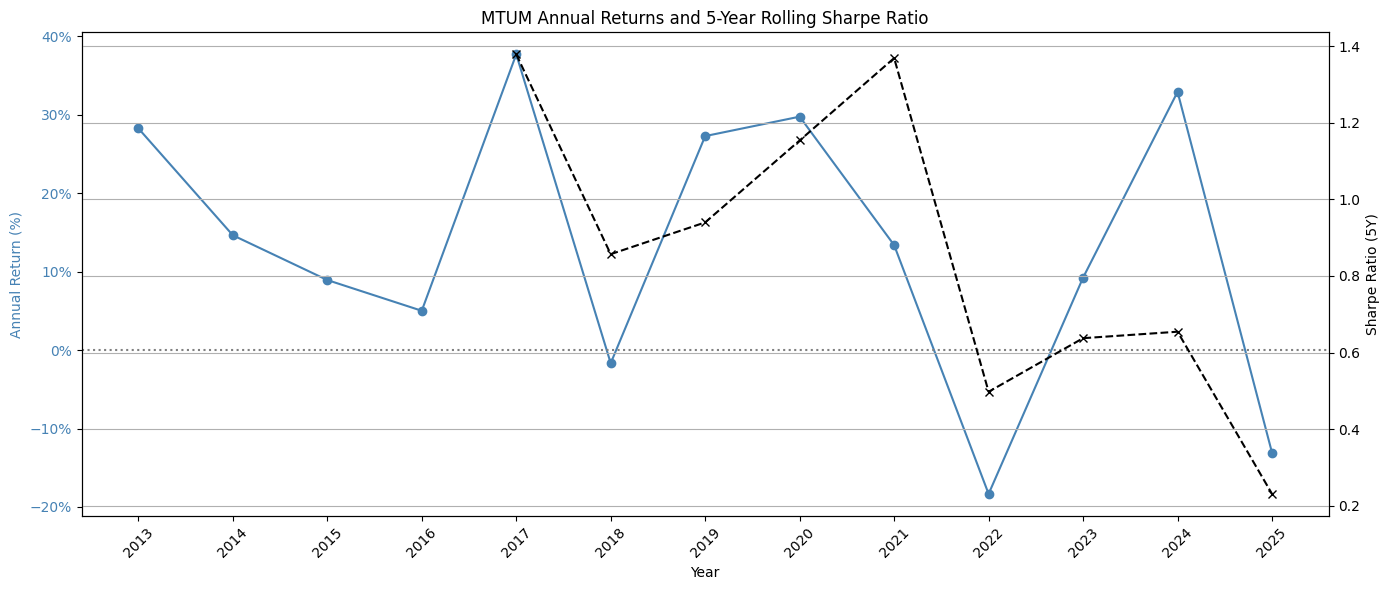

In [ ]:
# Create a dual-axis plot
fig, ax1 = plt.subplots(figsize=(14, 6))

# First axis: Annual returns
ax1.plot(annual_returns.index, annual_returns.values, label='Annual Return', color='steelblue', marker='o')
ax1.set_ylabel('Annual Return (%)', color='steelblue')
ax1.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax1.tick_params(axis='y', labelcolor='steelblue')
ax1.set_xlabel('Year')
ax1.set_xticks(annual_returns.index)
ax1.set_xticklabels(annual_returns.index, rotation=45)

# Second axis: 5-year rolling Sharpe ratio
ax2 = ax1.twinx()
ax2.plot(rolling_sharpe.index, rolling_sharpe.values, label='5Y Rolling Sharpe Ratio', color='Black', linestyle='--', marker='x')
ax2.set_ylabel('Sharpe Ratio (5Y)', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Title and formatting
plt.title('MTUM Annual Returns and 5-Year Rolling Sharpe Ratio')
ax1.axhline(0, color='gray', linestyle=':')
fig.tight_layout()
plt.grid(True)
plt.show()


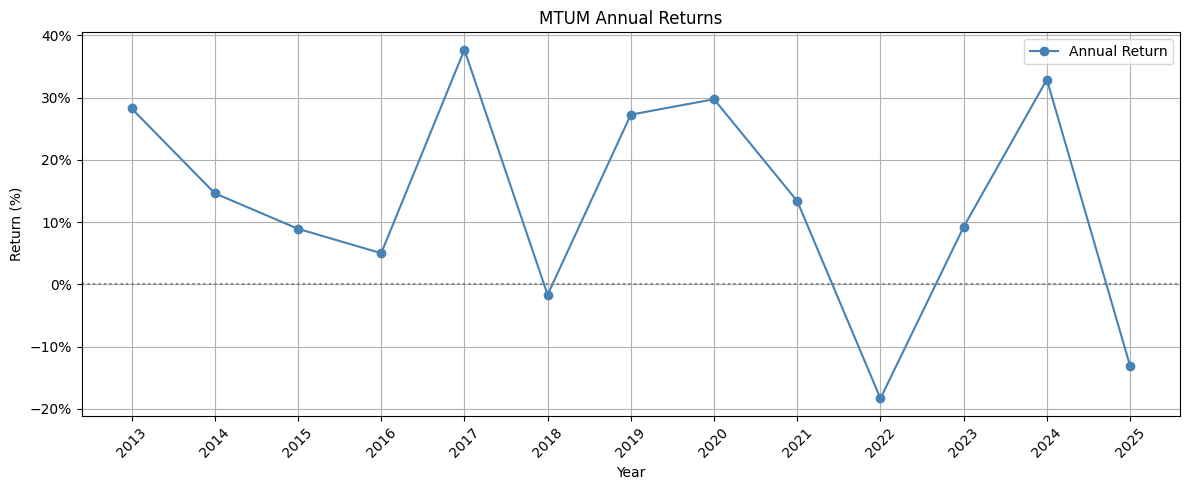

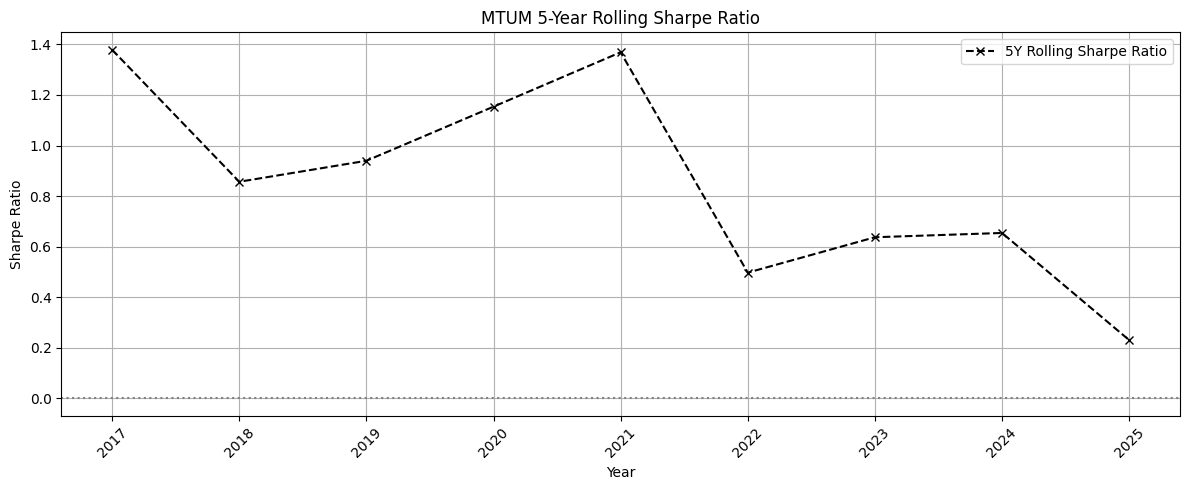

In [ ]:
# --- Plot 1: Annual Returns ---
plt.figure(figsize=(12, 5))
plt.plot(annual_returns.index, annual_returns.values, label='Annual Return', color='steelblue', marker='o')
plt.title('MTUM Annual Returns')
plt.xlabel('Year')
plt.ylabel('Return (%)')
plt.xticks(ticks=annual_returns.index, rotation=45)
plt.axhline(0, color='gray', linestyle=':')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

# --- Plot 2: 5-Year Rolling Sharpe Ratio ---
plt.figure(figsize=(12, 5))
plt.plot(rolling_sharpe.index, rolling_sharpe.values, label='5Y Rolling Sharpe Ratio', color='black', linestyle='--', marker='x')
plt.title('MTUM 5-Year Rolling Sharpe Ratio')
plt.xlabel('Year')
plt.ylabel('Sharpe Ratio')
plt.xticks(ticks=rolling_sharpe.index, rotation=45)
plt.axhline(0, color='gray', linestyle=':')
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()


## Comparative performance analysis:

[*********************100%***********************]  1 of 1 completed


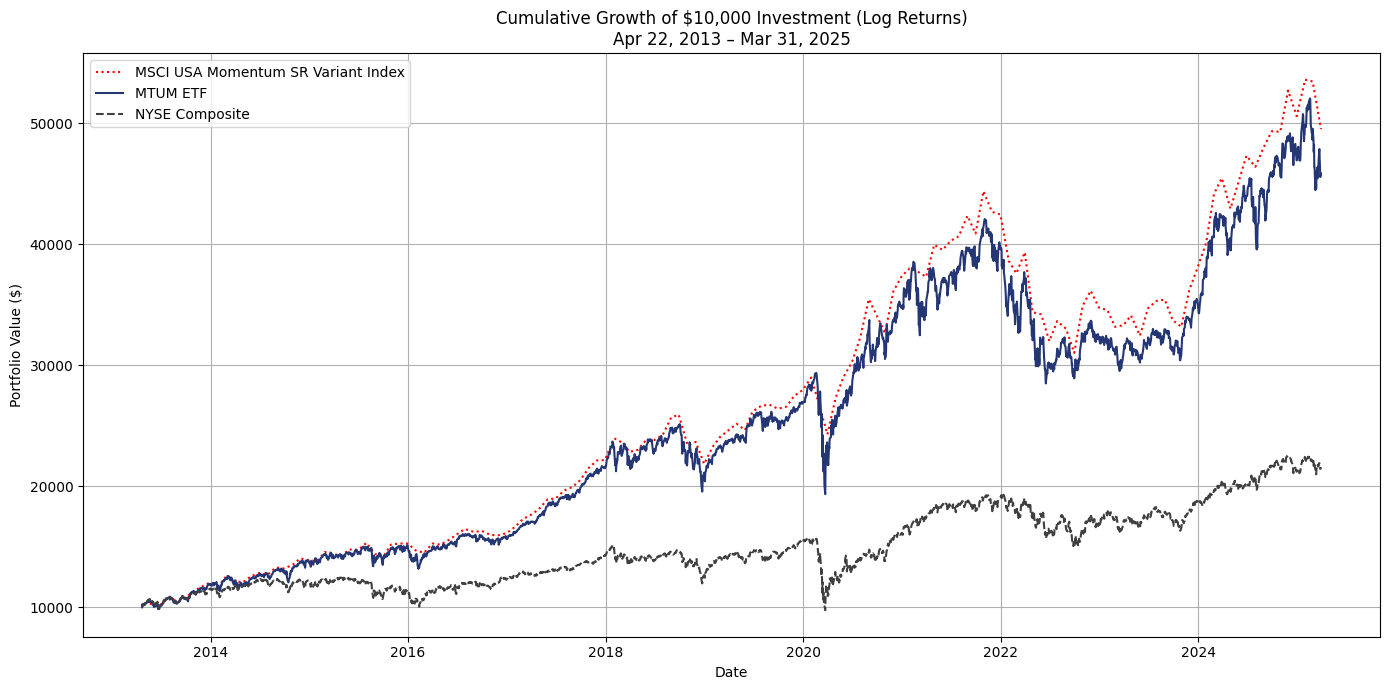

In [ ]:
# --- Step 1: Temporary copy of MTUM ---
mtum_temp = mtum.copy()
if 'Log_Return' not in mtum_temp.columns:
    mtum_temp['Log_Return'] = np.log(mtum_temp['Close'] / mtum_temp['Close'].shift(1))

# --- Step 2: Download NYSE Composite aligned to MTUM ---
nyse = yf.download('^NYA', start=mtum_temp.index[0].strftime('%Y-%m-%d'), end=mtum_temp.index[-1].strftime('%Y-%m-%d'))
nyse_temp = nyse.copy()
nyse_temp['Log_Return'] = np.log(nyse_temp['Close'] / nyse_temp['Close'].shift(1))
nyse_temp.dropna(inplace=True)

# --- Step 3: Load MSCI Momentum Index ---
msci_temp = pd.read_csv("731834 - MSCI USA Momentum SR Variant Index.csv.csv")
msci_temp['Date'] = pd.to_datetime(msci_temp['Date'])
msci_temp.set_index('Date', inplace=True)
msci_temp = msci_temp.rename(columns={'Value': 'MSCI Momentum SR'})
msci_temp['Log_Return'] = np.log(msci_temp['MSCI Momentum SR'] / msci_temp['MSCI Momentum SR'].shift(1))
msci_temp.dropna(inplace=True)

# --- Step 4: Drop NA from MTUM only now that we're sure it's ready ---
mtum_temp.dropna(inplace=True)

# --- Step 5: Find common date range ---
common_start = max(mtum_temp.index[0], nyse_temp.index[0], msci_temp.index[0])
common_end   = min(mtum_temp.index[-1], nyse_temp.index[-1], msci_temp.index[-1])

# --- Step 6: Align all to common date range ---
mtum_plot = mtum_temp.loc[common_start:common_end].copy()
nyse_plot = nyse_temp.loc[common_start:common_end].copy()
msci_plot = msci_temp.loc[common_start:common_end].copy()

# --- Step 7: Compute cumulative values from $10,000 ---
initial_investment = 10000
mtum_plot['Cumulative_Value'] = initial_investment * np.exp(mtum_plot['Log_Return'].cumsum())
nyse_plot['Cumulative_Value'] = initial_investment * np.exp(nyse_plot['Log_Return'].cumsum())
msci_plot['Cumulative_Value'] = initial_investment * np.exp(msci_plot['Log_Return'].cumsum())

# --- Step 8: Plot comparison ---
plt.figure(figsize=(14, 7))
plt.plot(msci_plot.index, msci_plot['Cumulative_Value'], label='MSCI USA Momentum SR Variant Index', color='red', linestyle=':')
plt.plot(mtum_plot.index, mtum_plot['Cumulative_Value'], label='MTUM ETF', color='#243673')
plt.plot(nyse_plot.index, nyse_plot['Cumulative_Value'], label='NYSE Composite', color='#3F4042', linestyle='--')
plt.title(f"Cumulative Growth of $10,000 Investment (Log Returns)\n{common_start.strftime('%b %d, %Y')} – {common_end.strftime('%b %d, %Y')}")
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



[*********************100%***********************]  1 of 1 completed


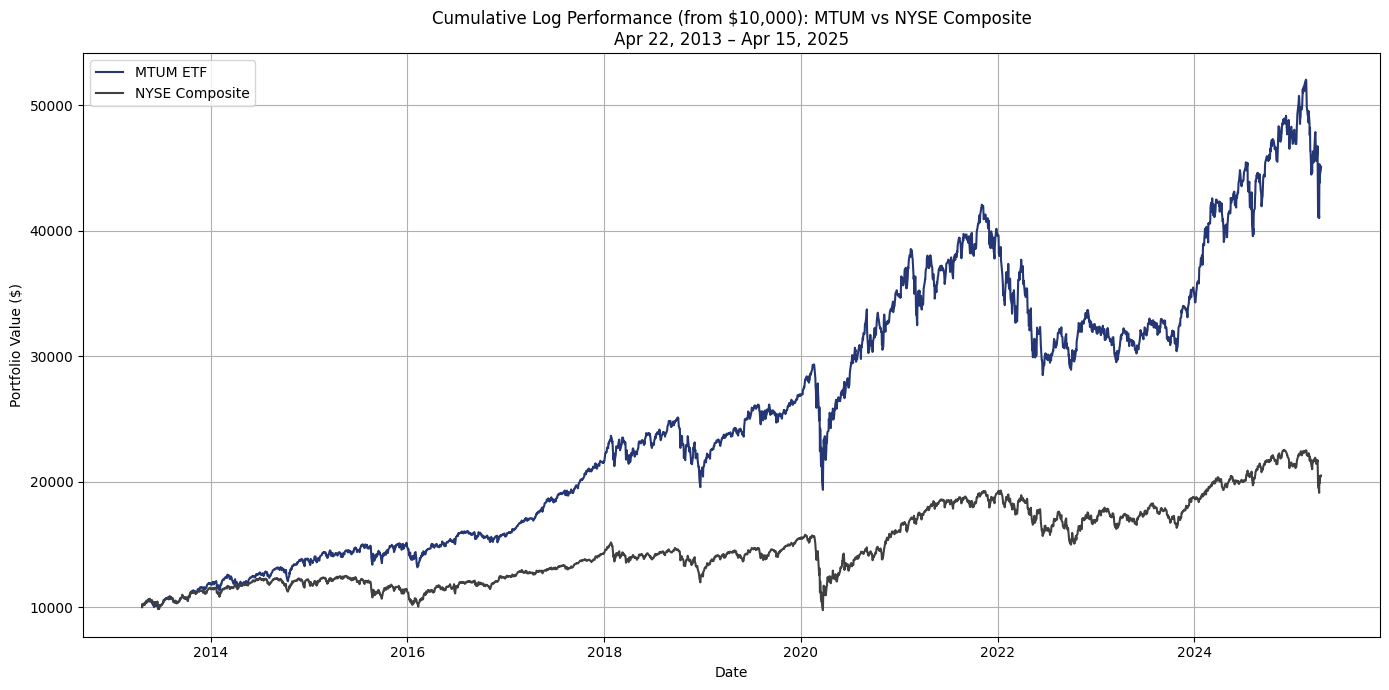

In [ ]:
# --- Step 1: Copia temporanea di MTUM ---
mtum_temp = mtum.copy()

# --- Step 2: Calcola Log_Return se non esiste ---
if 'Log_Return' not in mtum_temp.columns:
    mtum_temp['Log_Return'] = np.log(mtum_temp['Close'] / mtum_temp['Close'].shift(1))

# --- Step 3: Scarica NYSE Composite con massimo range ---
nyse = yf.download('^NYA', start=mtum_temp.index[0].strftime('%Y-%m-%d'), end='2025-04-17')
nyse_temp = nyse.copy()
nyse_temp['Log_Return'] = np.log(nyse_temp['Close'] / nyse_temp['Close'].shift(1))

# --- Step 4: Drop NA globalmente (non subset) ---
mtum_temp.dropna(inplace=True)
nyse_temp.dropna(inplace=True)

# --- Step 5: Allineamento sulle date comuni ---
common_dates = mtum_temp.index.intersection(nyse_temp.index)
mtum_plot = mtum_temp.loc[common_dates].copy()
nyse_plot = nyse_temp.loc[common_dates].copy()

# --- Step 6: Calcolo cumulative value da $10.000 ---
initial_investment = 10000
mtum_plot['Cumulative_Value'] = initial_investment * np.exp(mtum_plot['Log_Return'].cumsum())
nyse_plot['Cumulative_Value'] = initial_investment * np.exp(nyse_plot['Log_Return'].cumsum())

# --- Step 7: Plot ---
plt.figure(figsize=(14, 7))
plt.plot(mtum_plot.index, mtum_plot['Cumulative_Value'], label='MTUM ETF', color='#243673')
plt.plot(nyse_plot.index, nyse_plot['Cumulative_Value'], label='NYSE Composite', color='#3F4042')
plt.title(f'Cumulative Log Performance (from $10,000): MTUM vs NYSE Composite\n{common_dates[0].strftime("%b %d, %Y")} – {common_dates[-1].strftime("%b %d, %Y")}')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

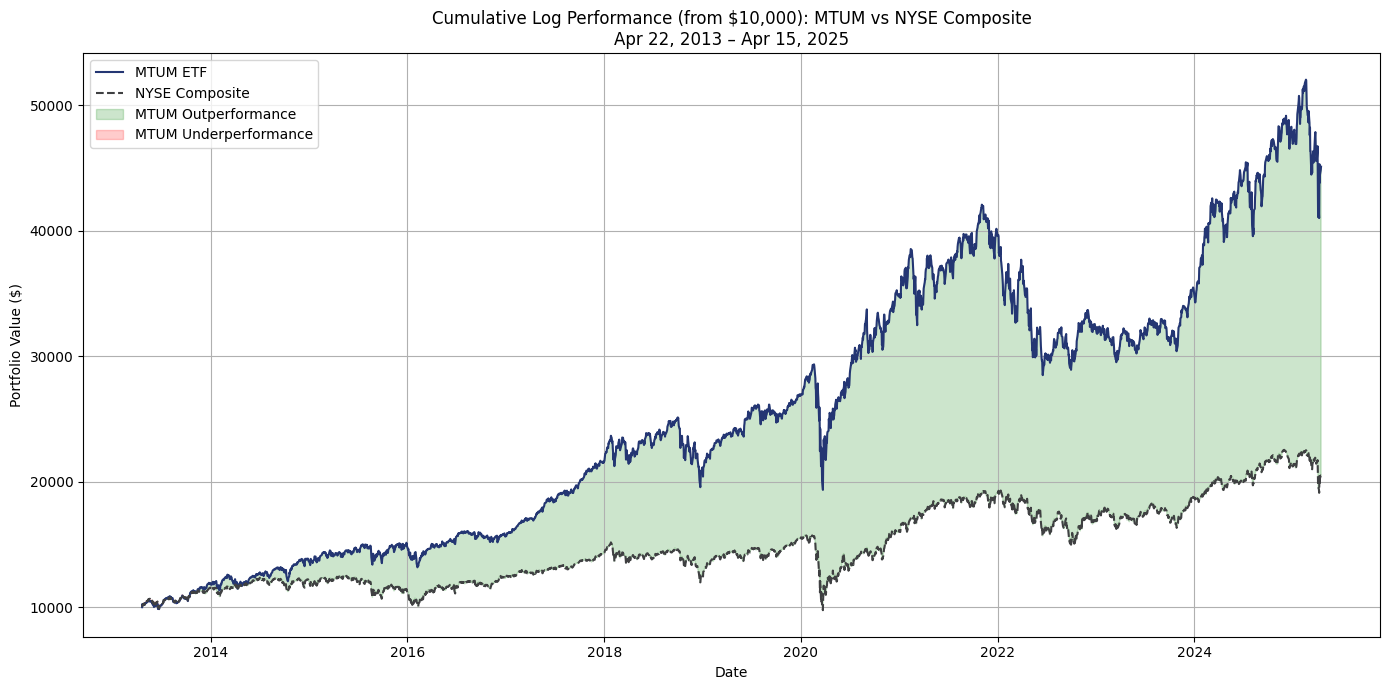

In [ ]:
# --- Plot with shaded area showing MTUM vs NYSE (from $10,000) ---
plt.figure(figsize=(14, 7))

# Plot MTUM and NYSE performance lines
plt.plot(mtum_plot.index, mtum_plot['Cumulative_Value'], label='MTUM ETF', color='#243673')
plt.plot(nyse_plot.index, nyse_plot['Cumulative_Value'], label='NYSE Composite', color='#3F4042', linestyle='--')

# Shade green when MTUM outperforms NYSE
plt.fill_between(
    mtum_plot.index,
    mtum_plot['Cumulative_Value'],
    nyse_plot['Cumulative_Value'],
    where=(mtum_plot['Cumulative_Value'] > nyse_plot['Cumulative_Value']),
    interpolate=True,
    color='green',
    alpha=0.2,
    label='MTUM Outperformance'
)

# Shade red when NYSE outperforms MTUM
plt.fill_between(
    mtum_plot.index,
    mtum_plot['Cumulative_Value'],
    nyse_plot['Cumulative_Value'],
    where=(mtum_plot['Cumulative_Value'] < nyse_plot['Cumulative_Value']),
    interpolate=True,
    color='red',
    alpha=0.2,
    label='MTUM Underperformance'
)

# Chart formatting
plt.title(f'Cumulative Log Performance (from $10,000): MTUM vs NYSE Composite\n{mtum_plot.index[0].strftime("%b %d, %Y")} – {mtum_plot.index[-1].strftime("%b %d, %Y")}')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



[*********************100%***********************]  1 of 1 completed


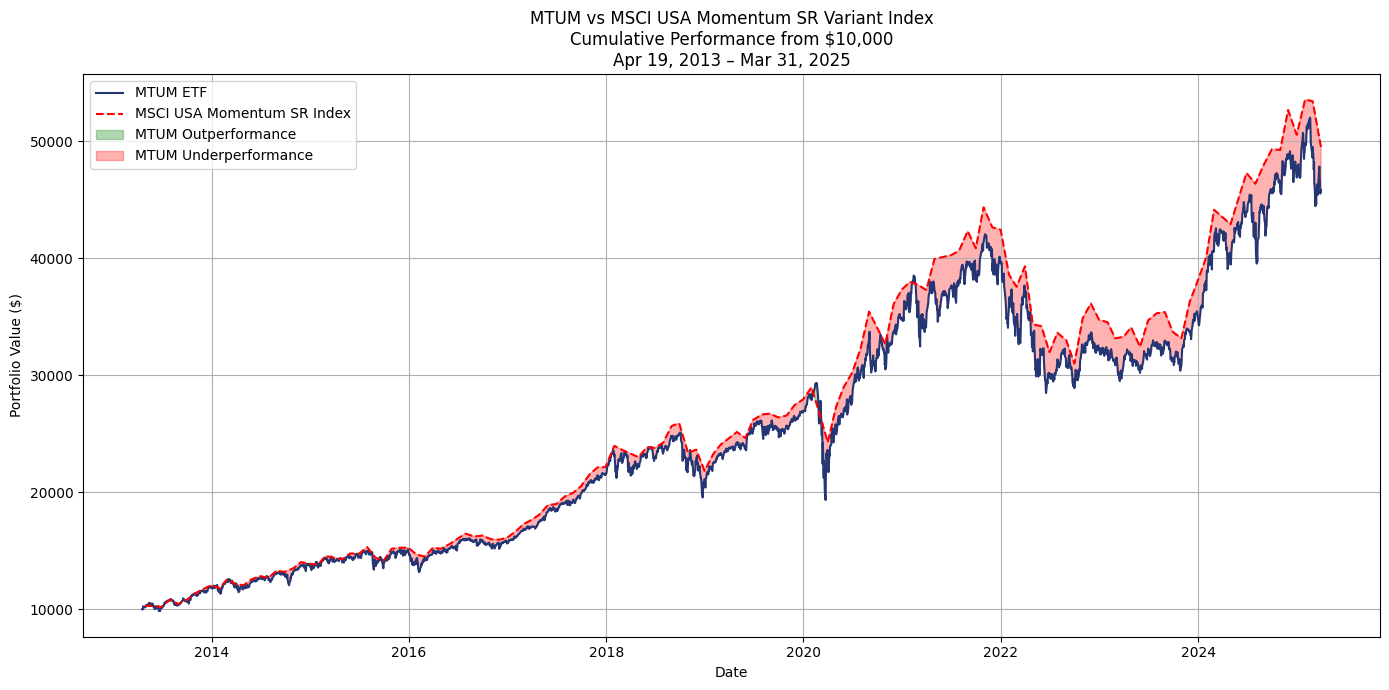

In [ ]:
# --- Step 1: Reload MTUM and create temporary copy ---
mtum_temp = yf.download('MTUM', start='2013-01-01', end='2025-04-17')
mtum_temp['Log_Return'] = np.log(mtum_temp['Close'] / mtum_temp['Close'].shift(1))
mtum_temp.dropna(inplace=True)

# --- Step 2: Load MSCI USA Momentum SR Variant Index ---
momentum_index = pd.read_csv("731834 - MSCI USA Momentum SR Variant Index.csv.csv")
momentum_index['Date'] = pd.to_datetime(momentum_index['Date'])
momentum_index.set_index('Date', inplace=True)
momentum_index = momentum_index.rename(columns={'Value': 'MSCI Momentum SR'})
momentum_index['Log_Return'] = np.log(momentum_index['MSCI Momentum SR'] / momentum_index['MSCI Momentum SR'].shift(1))
momentum_index.dropna(inplace=True)

# --- Step 3: Align date range ---
common_start = max(mtum_temp.index[0], momentum_index.index[0])
common_end = min(mtum_temp.index[-1], momentum_index.index[-1])
mtum_plot = mtum_temp.loc[common_start:common_end].copy()
msci_plot = momentum_index.loc[common_start:common_end].copy()

# --- Step 4: Compute cumulative value from $10,000 ---
initial_investment = 10000
mtum_plot['Cumulative_Value'] = initial_investment * np.exp(mtum_plot['Log_Return'].cumsum())
msci_plot['Cumulative_Value'] = initial_investment * np.exp(msci_plot['Log_Return'].cumsum())

# --- Step 5: Interpolate MSCI on MTUM dates for matching index ---
msci_interp = msci_plot['Cumulative_Value'].reindex(mtum_plot.index).interpolate(method='time')

# --- Step 6: Plot with shaded areas for over/underperformance ---
plt.figure(figsize=(14, 7))

# Line plots
plt.plot(mtum_plot.index, mtum_plot['Cumulative_Value'], label='MTUM ETF', color='#243673')
plt.plot(mtum_plot.index, msci_interp, label='MSCI USA Momentum SR Index', color='red', linestyle='--')

# Green shading when MTUM > MSCI
plt.fill_between(
    mtum_plot.index,
    mtum_plot['Cumulative_Value'],
    msci_interp,
    where=(mtum_plot['Cumulative_Value'] > msci_interp),
    color='green',
    alpha=0.3,
    label='MTUM Outperformance'
)

# Red shading when MSCI > MTUM
plt.fill_between(
    mtum_plot.index,
    mtum_plot['Cumulative_Value'],
    msci_interp,
    where=(mtum_plot['Cumulative_Value'] < msci_interp),
    color='red',
    alpha=0.3,
    label='MTUM Underperformance'
)

# Final styling
plt.title(f'MTUM vs MSCI USA Momentum SR Variant Index\nCumulative Performance from $10,000\n{mtum_plot.index[0].strftime("%b %d, %Y")} – {mtum_plot.index[-1].strftime("%b %d, %Y")}')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Has Momentum Lost Its Strength Since COVID? A Pre/Post Performance Comparison

## T-Test: Pre vs Post COVID

In [ ]:
# =============================================
# STEP 1–6: MTUM vs NYSE Analysis (Annual Max Loss)
# =============================================

# ---------------------------------------------
# Download NYSE data
# ---------------------------------------------

nyse = yf.download('^NYA', start=mtum.index[0].strftime('%Y-%m-%d'), end='2025-04-17')

# ---------------------------------------------
# Extract Year from index
# ---------------------------------------------

mtum['Year'] = mtum.index.year
nyse['Year'] = nyse.index.year

# ---------------------------------------------
# Compute Log Returns if missing
# ---------------------------------------------

if 'Log_Return' not in mtum.columns:
    mtum['Log_Return'] = np.log(mtum['Close'] / mtum['Close'].shift(1))
if 'Log_Return' not in nyse.columns:
    nyse['Log_Return'] = np.log(nyse['Close'] / nyse['Close'].shift(1))

# ---------------------------------------------
# Compute Annual Log Returns (geometric)
# ---------------------------------------------

annual_log_mtum = np.exp(mtum.groupby('Year')['Log_Return'].sum()) - 1
annual_log_nyse = np.exp(nyse.groupby('Year')['Log_Return'].sum()) - 1

# ---------------------------------------------
# Common years and performance difference
# ---------------------------------------------

common_years = annual_log_mtum.index.intersection(annual_log_nyse.index)
diff = annual_log_mtum[common_years] - annual_log_nyse[common_years]

# ---------------------------------------------
# Define pre- and post-COVID periods
# ---------------------------------------------

pre = common_years[(common_years >= 2013) & (common_years <= 2019)]
post = common_years[(common_years >= 2020) & (common_years <= 2024)]

# ---------------------------------------------
# Compute differences for each period
# ---------------------------------------------

pre_diff = diff[pre]
post_diff = diff[post]

# MTUM only
mtum_pre_returns = annual_log_mtum[pre]
mtum_post_returns = annual_log_mtum[post]

# =============================================
# Metrics Function: Max Drawdown = Worst Year
# =============================================

def clean_metrics(name, series):
    return pd.Series({
        'Mean Return': series.mean(),
        'Std Dev': series.std(),
        'Sharpe (Rf=0)': series.mean() / series.std() if series.std() != 0 else np.nan,
        '% Positive Years': (series > 0).mean(),
    }, name=name)

# =============================================
# Create Metrics Table
# =============================================

metrics_df = pd.concat([
    clean_metrics('MTUM Pre', mtum_pre_returns),
    clean_metrics('MTUM Post', mtum_post_returns),
    clean_metrics('NYSE Pre', annual_log_nyse[pre]),
    clean_metrics('NYSE Post', annual_log_nyse[post])
], axis=1)



[*********************100%***********************]  1 of 1 completed


In [ ]:
# =============================================
# STYLE DEFINITIONS
# =============================================

custom_style = [

    # Table base with outer black border
    {
        'selector': 'table',
        'props': [
            ('border', '2px solid black'),        # Outer border
            ('background-color', 'white'),      # Light gray
            ('color', 'white'),                 # Dark text
            ('width', '100%'),
            ('border-collapse', 'collapse'),
            ('font-family', 'Roboto, sans-serif'),
            ('table-layout', 'fixed')
        ]
    },

    # Text formatting
    {
        'selector': 'th, td',
        'props': [
            ('padding', '8px 12px'),
            ('text-align', 'center'),
            ('color', '#595959'),
            ('font-weight', 'bold'),
            ('font-family', 'Roboto, sans-serif')
        ]
    },

    # Row background
    {
        'selector': 'tr',
        'props': [
            ('background-color', 'white')
        ]
    },

    # Header style
    {
        'selector': 'th',
        'props': [
            ('border-bottom', '2px solid #595959'),
            ('font-size', '14px'),
            ('text-align', 'center')
        ]
    },

    # Caption
    {
        'selector': 'caption',
        'props': [
            ('color', 'white'),
            ('font-size', '16px'),
            ('font-weight', 'bold'),
            ('margin-bottom', '12px'),
            ('text-align', 'center')
        ]
    },

    # Horizontal row borders
    {
        'selector': 'tr td',
        'props': [
            ('border-bottom', '2px solid #595959')
        ]
    },

    # Vertical column borders
    {
        'selector': 'td:not(:first-child), th:not(:first-child)',
        'props': [
            ('border-left', '2px solid #595959')
        ]
    }
]

def percentage_format(x):
    """Format all numeric values as percentages with 2 decimal places"""
    if isinstance(x, (int, float)):
        return '{:.2f}%'.format(x * 100)
    return x

def conditional_format(x, column):
    """Format numbers as percentage, except for '% Positive Years' (just 2 decimals)"""
    if isinstance(x, (int, float)):
        if column == '% Positive Years':
            return '{:.2f}'.format(x)
        else:
            return '{:.2f}%'.format(x * 100)
    return x




In [ ]:
# =============================================
# CREATE & DISPLAY FINAL COMPARISON TABLE
# =============================================

# Select and prepare metrics
comparison_subset = metrics_df.loc[
    ['Mean Return', 'Std Dev', 'Sharpe (Rf=0)', '% Positive Years']
].copy()

# Rename column for clarity
comparison_subset.rename(index={'% Positive Years': 'Positive Years'}, inplace=True)

# Transpose and structure table
comparison_df = comparison_subset.T.reset_index()
comparison_df.columns = ['Strategy', 'Average Return', 'Std Dev', 'Sharpe Ratio (Rf=0)', 'Positive Years']

# Format all columns except 'Positive Years' as percentages
styled_comparison = (
    comparison_df.style
    .format({
        'Average Return': percentage_format,
        'Std Dev': percentage_format,
        'Sharpe Ratio (Rf=0)': percentage_format,
        'Positive Years': percentage_format
    })
    .set_table_styles(custom_style)
    .set_caption("Performance Comparison: MTUM vs NYSE (Pre vs Post COVID)")
    .hide(axis='index')
    .set_table_attributes('style="width:100%; table-layout:fixed;"')
)

# Display the styled table
display(styled_comparison)




Strategy,Average Return,Std Dev,Sharpe Ratio (Rf=0),Positive Years
MTUM Pre,15.83%,13.44%,117.76%,85.71%
MTUM Post,13.40%,20.44%,65.54%,80.00%
NYSE Pre,7.06%,12.32%,57.30%,71.43%
NYSE Post,7.07%,11.52%,61.35%,80.00%


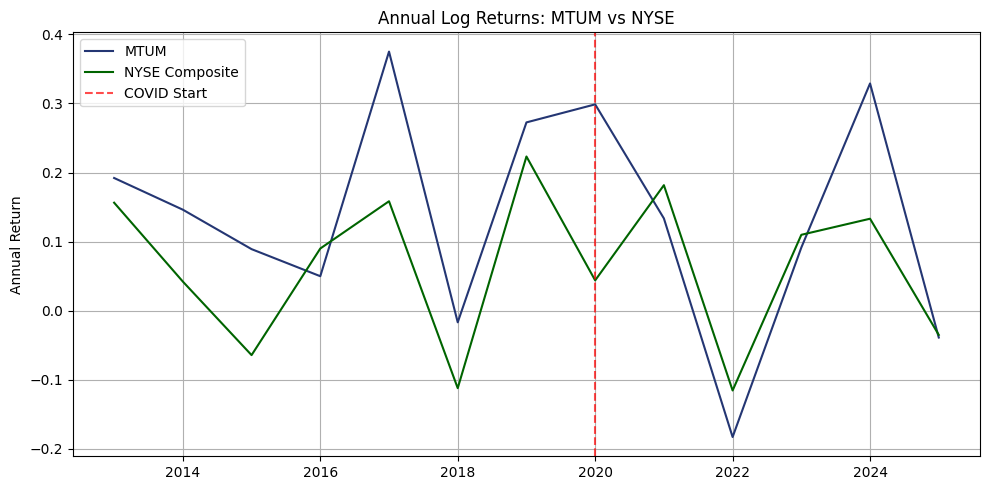

In [ ]:
# =============================================
# STEP 7: PLOT (Unchanged)
# =============================================

plt.figure(figsize=(10, 5))
plt.plot(annual_log_mtum.index, annual_log_mtum.values, label='MTUM', color='#243673')
plt.plot(annual_log_nyse.index, annual_log_nyse.values, label='NYSE Composite', color='darkgreen')
plt.axvline(2020, color='red', linestyle='--', alpha=0.7, label='COVID Start')
plt.title('Annual Log Returns: MTUM vs NYSE')
plt.ylabel('Annual Return')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# =============================================
# STEP 8: Hypothesis Testing (Simple T-Tests)
# =============================================

# ---------------------------------------------
# TEST 1: MTUM vs NYSE Performance Difference (Pre vs Post COVID)
# ---------------------------------------------

test1_stat, test1_pvalue = ttest_ind(pre_diff, post_diff, equal_var=False)

# ---------------------------------------------
# TEST 2: MTUM Annual Return Persistency (Pre vs Post COVID)
# ---------------------------------------------

test2_stat, test2_pvalue = ttest_ind(mtum_pre_returns, mtum_post_returns, equal_var=False)

# ---------------------------------------------
# Print test results
# ---------------------------------------------

print("===== Hypothesis Test Results =====\n")

print("Test 1: MTUM vs NYSE (Pre vs Post COVID)")
print(f"T-Statistic: {test1_stat:.4f}")
print(f"P-Value: {test1_pvalue:.4f}")
print("Significant difference" if test1_pvalue < 0.05 else "No significant difference")
print("\n")

print("Test 2: MTUM Return Persistency (Pre vs Post COVID)")
print(f"T-Statistic: {test2_stat:.4f}")
print(f"P-Value: {test2_pvalue:.4f}")
print("Significant difference" if test2_pvalue < 0.05 else "No significant difference")


===== Hypothesis Test Results =====

Test 1: MTUM vs NYSE (Pre vs Post COVID)
T-Statistic: 0.3292
P-Value: 0.7536
No significant difference


Test 2: MTUM Return Persistency (Pre vs Post COVID)
T-Statistic: 0.2327
P-Value: 0.8232
No significant difference


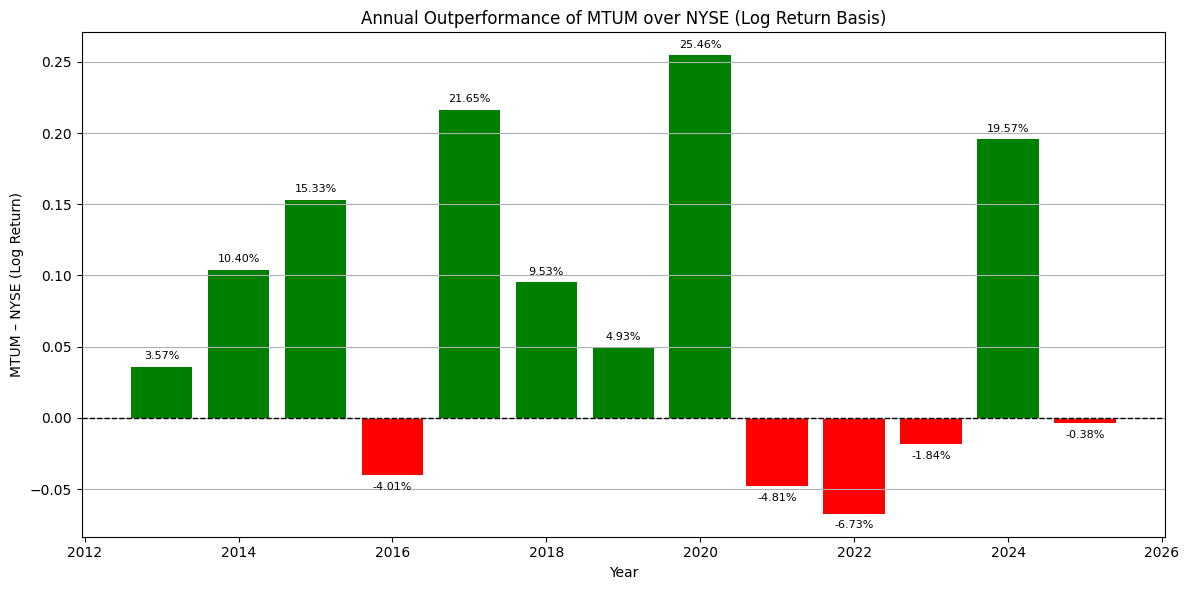

In [ ]:
# --- Step 11: Barplot with differential coloring MTUM vs NYSE ---

# Create aligned DataFrame for plotting
annual_comparison = pd.DataFrame({
    'MTUM': annual_log_mtum,
    'NYSE': annual_log_nyse
}).dropna()

# Compute difference
annual_comparison['Difference'] = annual_comparison['MTUM'] - annual_comparison['NYSE']

# Define bar colors based on outperformance
colors = ['green' if diff > 0 else 'red' for diff in annual_comparison['Difference']]

# Plot
fig, ax1 = plt.subplots(figsize=(12, 6))

# Bar chart for MTUM - NYSE difference
bars = ax1.bar(annual_comparison.index, annual_comparison['Difference'], color=colors)
ax1.axhline(0, color='black', linestyle='--', linewidth=1)
ax1.set_title("Annual Outperformance of MTUM over NYSE (Log Return Basis)")
ax1.set_ylabel("MTUM – NYSE (Log Return)")
ax1.set_xlabel("Year")
ax1.grid(True, axis='y')

# Add numerical labels on top of each bar
for bar in bars:
    height = bar.get_height()
    ax1.annotate(f'{height:.2%}',
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 4 if height >= 0 else -12),
                 textcoords="offset points",
                 ha='center', va='bottom',
                 fontsize=8)

plt.tight_layout()
plt.show()


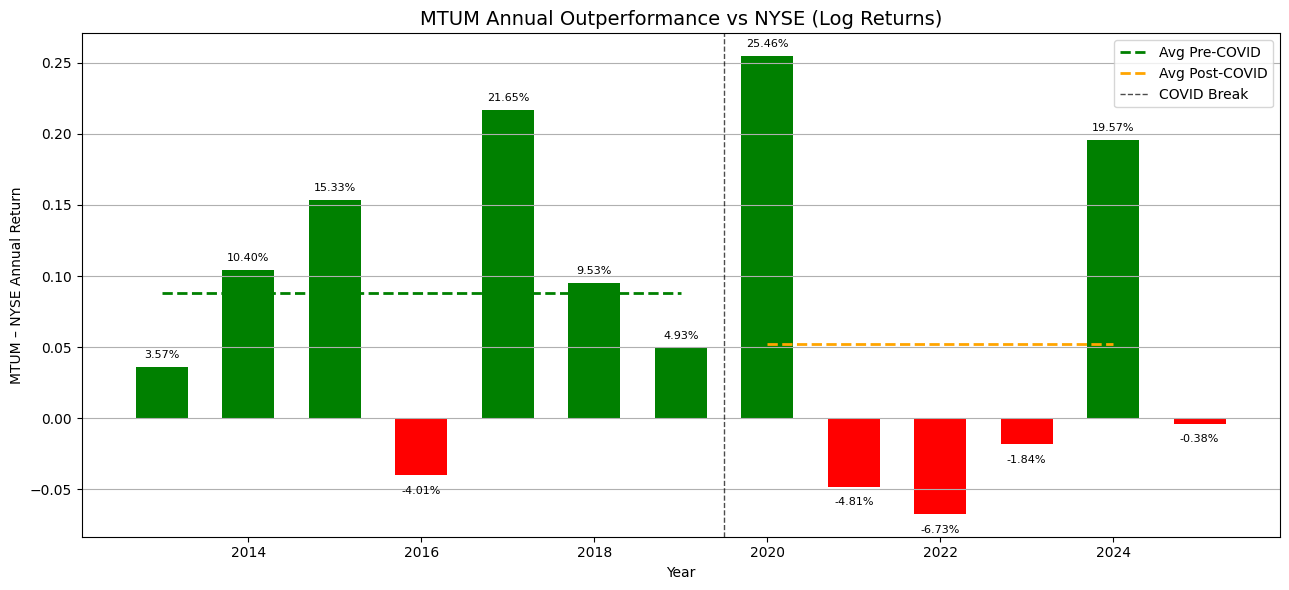

In [ ]:
# --- Step 11: Advanced Barplot: MTUM vs NYSE Annual Outperformance ---

import matplotlib.pyplot as plt

# Reuse annual_comparison if already computed
annual_comparison = pd.DataFrame({
    'MTUM': annual_log_mtum,
    'NYSE': annual_log_nyse
}).dropna()

# Compute difference and classify
annual_comparison['Difference'] = annual_comparison['MTUM'] - annual_comparison['NYSE']
annual_comparison['Period'] = ['Pre-COVID' if y < 2020 else 'Post-COVID' for y in annual_comparison.index]
colors = ['green' if diff > 0 else 'red' for diff in annual_comparison['Difference']]

# Compute averages
pre_mean = annual_comparison[annual_comparison['Period'] == 'Pre-COVID']['Difference'].mean()
post_mean = annual_comparison[annual_comparison['Period'] == 'Post-COVID']['Difference'].mean()

# Plot
fig, ax = plt.subplots(figsize=(13, 6))

# Bars: Difference MTUM - NYSE
bars = ax.bar(annual_comparison.index, annual_comparison['Difference'], color=colors, width=0.6)

# Line: Pre/Post average
ax.hlines(pre_mean, xmin=2013, xmax=2019, color='green', linestyle='dashed', linewidth=2, label='Avg Pre-COVID')
ax.hlines(post_mean, xmin=2020, xmax=2024, color='orange', linestyle='dashed', linewidth=2, label='Avg Post-COVID')

# Line: COVID cut-off
ax.axvline(2019.5, color='black', linestyle='--', linewidth=1, alpha=0.7, label='COVID Break')

# Label bars with values
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height:.2%}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 5 if height >= 0 else -15),
                textcoords="offset points",
                ha='center', va='bottom',
                fontsize=8)

# Title and axes
ax.set_title("MTUM Annual Outperformance vs NYSE (Log Returns)", fontsize=14)
ax.set_ylabel("MTUM – NYSE Annual Return")
ax.set_xlabel("Year")
ax.grid(True, axis='y')
ax.legend()
plt.tight_layout()
plt.show()


## Hypothesis Test: Is Momentum Still Profitable?

In [ ]:
# --- Step 1: Ensure 'Year' and 'Daily Return' exist ---
mtum['Year'] = mtum.index.year
if 'Daily Return' not in mtum.columns:
    mtum['Daily Return'] = mtum['Close'].pct_change()
mtum.dropna(inplace=True)

# --- Step 2: Compute annual compounded returns from daily returns ---
annual_returns = mtum.groupby('Year')['Daily Return'].apply(lambda x: (1 + x).prod() - 1).dropna()

# --- Step 3: One-sided one-sample t-test ---
# H₀: μ ≤ 0 (Momentum not profitable)
# H₁: μ > 0 (Momentum is profitable)
t_stat, p_value = stats.ttest_1samp(annual_returns, popmean=0)
p_one_sided = p_value / 2

# --- Step 4: Output for interpretation ---
print("Hypothesis Test: Is Momentum Still Profitable?")
print("------------------------------------------------")
print(f"Mean Annual Return: {annual_returns.mean():.2%}")
print(f"Standard Deviation: {annual_returns.std():.2%}")
print(f"T-statistic: {t_stat:.2f}")
print(f"One-sided P-value: {p_one_sided:.4f}")

# --- Step 5: Conclusion ---
alpha = 0.05
if (t_stat > 0) and (p_one_sided < alpha):
    print("Reject H₀: The strategy has a statistically positive expected return.")
else:
    print("Fail to reject H₀: No significant evidence of positive expected return.")



Hypothesis Test: Is Momentum Still Profitable?
------------------------------------------------
Mean Annual Return: 13.38%
Standard Deviation: 16.06%
T-statistic: 3.00
One-sided P-value: 0.0055
Reject H₀: The strategy has a statistically positive expected return.


## Stationarity & Autocorrelation Diagnostics

### Part 1 – In-sample Forecasting with ARIMA + GARCH

In this section, we implement a classic two-stage time series modeling framework to assess how well our ARIMA-GARCH setup forecasts volatility on out-of-sample data.

1. **Train/Test Split**: The dataset of MTUM log returns is split into a training set (80%) and a test set (20%).
2. **ARIMA Modeling**: We fit an ARIMA(1,0,1) model on the training set to model the conditional mean of returns.
3. **GARCH Modeling**: The residuals from the ARIMA model are used to fit a GARCH(1,1) model, capturing time-varying volatility.
4. **Volatility Forecast**: We forecast conditional volatility over the test set and compare the **predicted standard deviations** with the **realized log returns**.

The goal is to evaluate how well the model captures return dynamics and volatility over unseen data.


[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001541. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


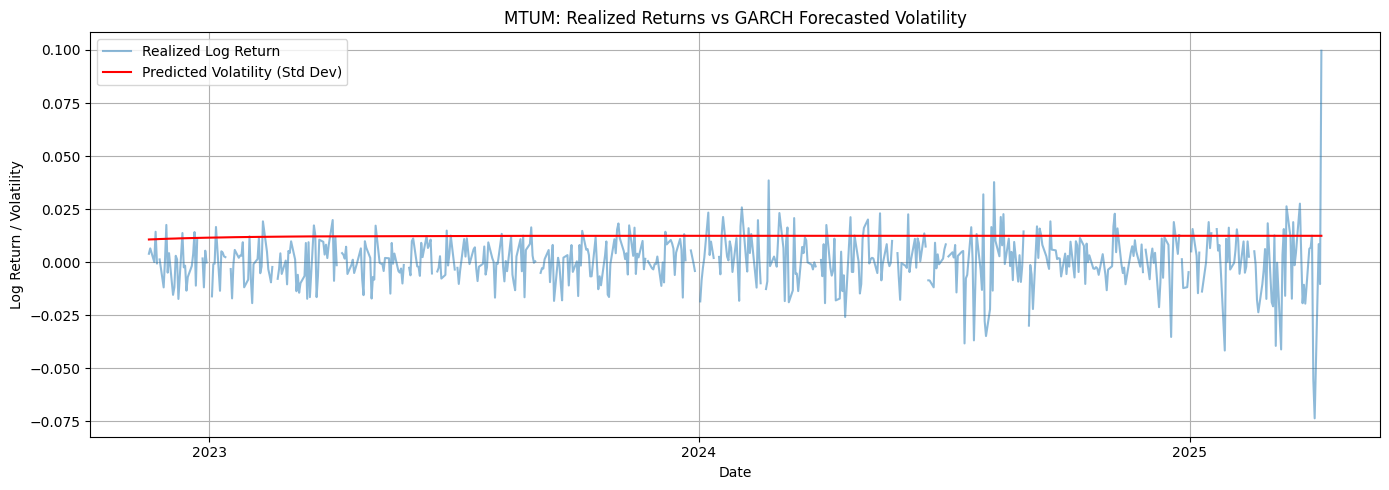

In [ ]:
# --- Download data ---
mtum = yf.download('MTUM', start='2012-01-01', end='2025-04-10')

# --- Compute log returns ---
mtum['Log_Return'] = np.log(mtum['Close'] / mtum['Close'].shift(1))

# --- Drop ALL NaN values just to be safe ---
mtum.dropna(inplace=True)

# --- Optional: Set frequency to avoid forecast warnings ---
mtum = mtum.asfreq('B')

# --- STEP 1: Train/test split ---
split_index = int(len(mtum) * 0.8)
train_returns = mtum['Log_Return'].iloc[:split_index]
test_returns = mtum['Log_Return'].iloc[split_index:]

# --- STEP 2: Fit ARIMA on training set ---
arima_model = ARIMA(train_returns, order=(1, 0, 1)).fit()
residuals = arima_model.resid
residuals = residuals[np.isfinite(residuals)]  # <- this fixes the issue!

# --- STEP 3: Fit GARCH(1,1) on ARIMA residuals ---
garch_model = arch_model(residuals, vol='Garch', p=1, q=1)
garch_fit = garch_model.fit(disp="off")

# --- STEP 4: Forecast volatility for the test period ---
garch_forecast = garch_fit.forecast(horizon=len(test_returns), reindex=False)
predicted_volatility = np.sqrt(garch_forecast.variance.values[-1, :])

# --- STEP 5: Create comparison DataFrame ---
forecast_df = pd.DataFrame({
    'Date': test_returns.index,
    'Realized_Returns': test_returns.values,
    'Predicted_StdDev': predicted_volatility
}).set_index('Date')

# --- STEP 6: Plot realized vs predicted volatility ---
plt.figure(figsize=(14, 5))
plt.plot(forecast_df.index, forecast_df['Realized_Returns'], label='Realized Log Return', alpha=0.5)
plt.plot(forecast_df.index, forecast_df['Predicted_StdDev'], label='Predicted Volatility (Std Dev)', color='red')
plt.title('MTUM: Realized Returns vs GARCH Forecasted Volatility')
plt.xlabel('Date')
plt.ylabel('Log Return / Volatility')
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()





### Part 2 – Long-Term Forecast Simulation (3-Year Path)

This section uses the **entire historical dataset** to estimate the ARIMA-GARCH model, which is then used to **simulate a 3-year forward-looking return path**.

The process involves:
1. **Fitting ARIMA + GARCH**: The ARIMA(1,0,1) model captures the return structure, while GARCH(1,1) models time-varying volatility.
2. **Forecasting Future Returns**:
   - The conditional mean (ARIMA forecast) is added to random noise drawn from a normal distribution with volatility from the GARCH forecast.
3. **Simulating Future Prices**:
   - We exponentiate the cumulative sum of the simulated log returns to build a synthetic MTUM price path, starting from the last observed value.
4. **Plotting**:
   - We compare the historical cumulative return path with the simulated future path for visual inspection of model expectations.

This helps visualize what the MTUM strategy might look like if future conditions were to resemble historical return-volatility dynamics.

/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000154. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


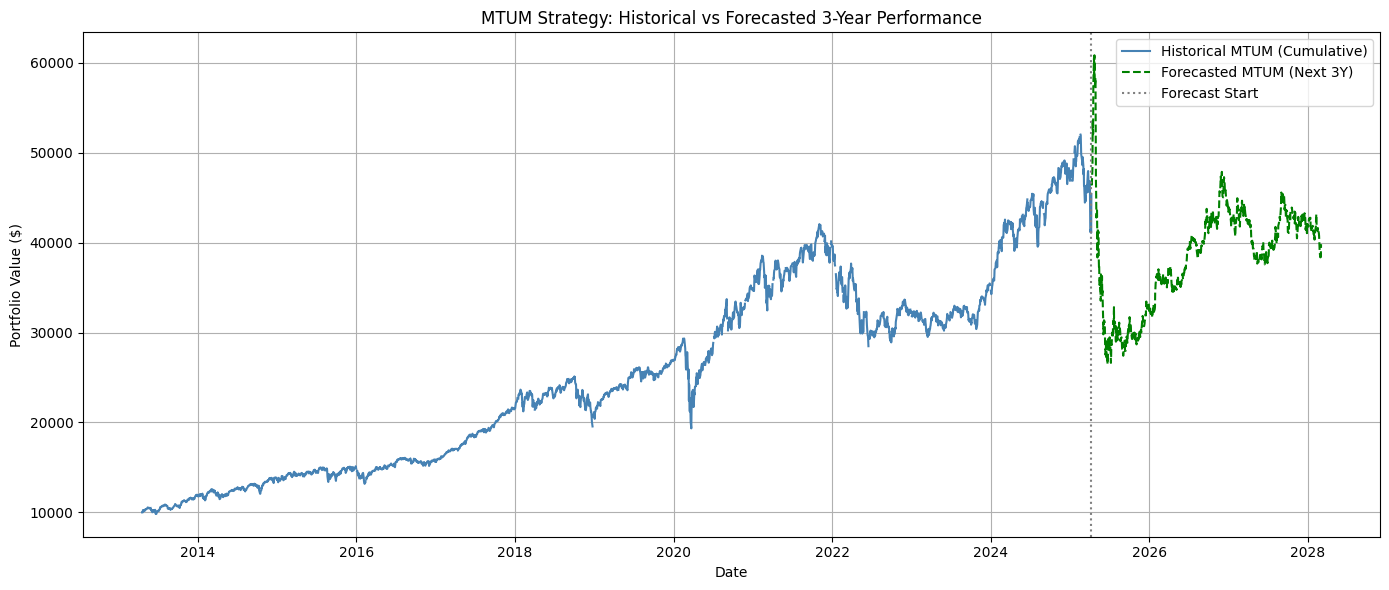

In [ ]:
# --- STEP 1: Simulate Historical Cumulative Path ---
historical_prices = 10000 * np.exp(mtum['Log_Return'].cumsum())

# --- STEP 2: Fit ARIMA and GARCH on full dataset ---
arima_model = ARIMA(mtum['Log_Return'], order=(1, 0, 1)).fit()
arima_residuals = arima_model.resid
arima_residuals = arima_residuals[np.isfinite(arima_residuals)]

garch_model = arch_model(arima_residuals, vol='Garch', p=1, q=1)
garch_fit = garch_model.fit(disp='off')

# --- STEP 3: Forecast Parameters ---
forecast_horizon = 252 * 3  # simulate 3 years (business days)
arima_forecast = arima_model.forecast(steps=forecast_horizon)
garch_forecast = garch_fit.forecast(horizon=forecast_horizon, method='simulation')
simulated_std = np.sqrt(garch_forecast.variance.values[-1])

# --- STEP 4: Simulate Log Returns ---
np.random.seed(42)  # reproducibility
simulated_returns = arima_forecast + np.random.normal(scale=simulated_std, size=forecast_horizon)

# --- STEP 5: Simulate Forecasted Price Path ---
starting_value = historical_prices.iloc[-1]
forecasted_prices = starting_value * np.exp(np.cumsum(simulated_returns))

# --- STEP 6: Create Synthetic Forecast Timeline ---
forecast_index = pd.date_range(start=mtum.index[-1] + pd.Timedelta(days=1), periods=forecast_horizon, freq='B')

# --- STEP 7: Plot Historical vs Forecasted Prices ---
plt.figure(figsize=(14, 6))
plt.plot(mtum.index, historical_prices, label='Historical MTUM (Cumulative)', color='steelblue')
plt.plot(forecast_index, forecasted_prices, label='Forecasted MTUM (Next 3Y)', color='green', linestyle='--')
plt.axvline(mtum.index[-1], color='gray', linestyle=':', label='Forecast Start')
plt.title('MTUM Strategy: Historical vs Forecasted 3-Year Performance')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


### Part 3 – Residual Diagnostics and Model Validation

In this section, we evaluate whether the residuals from the ARIMA model satisfy basic statistical assumptions:

1. **Normality Test (Jarque-Bera)**:
   - Checks whether residuals resemble a normal distribution.
   - Rejecting the null implies skewness and/or kurtosis significantly differ from normal.

2. **Autocorrelation Test (Ljung-Box)**:
   - Examines whether autocorrelations remain in the residuals.
   - Significant p-values suggest the ARIMA model failed to fully capture temporal structure.

3. **Residual Plots**:
   - **Histogram**: Assesses distribution shape.
   - **QQ Plot**: Compares quantiles of residuals with a normal distribution.
   - **ACF & PACF**: Reveal any remaining autocorrelation patterns.

These diagnostics help validate the appropriateness of the ARIMA-GARCH framework before using it for inference or forecasting.

Jarque-Bera Test for Normality:
JB Statistic: 15117.58
P-value: 0.0000
=> Reject H₀ (normality)? Yes


Ljung-Box Test for Autocorrelation:


,lb_stat,lb_pvalue
10,100.326339,4.688690e-17
20,132.372655,1.396762e-18
30,158.976096,1.680237e-19


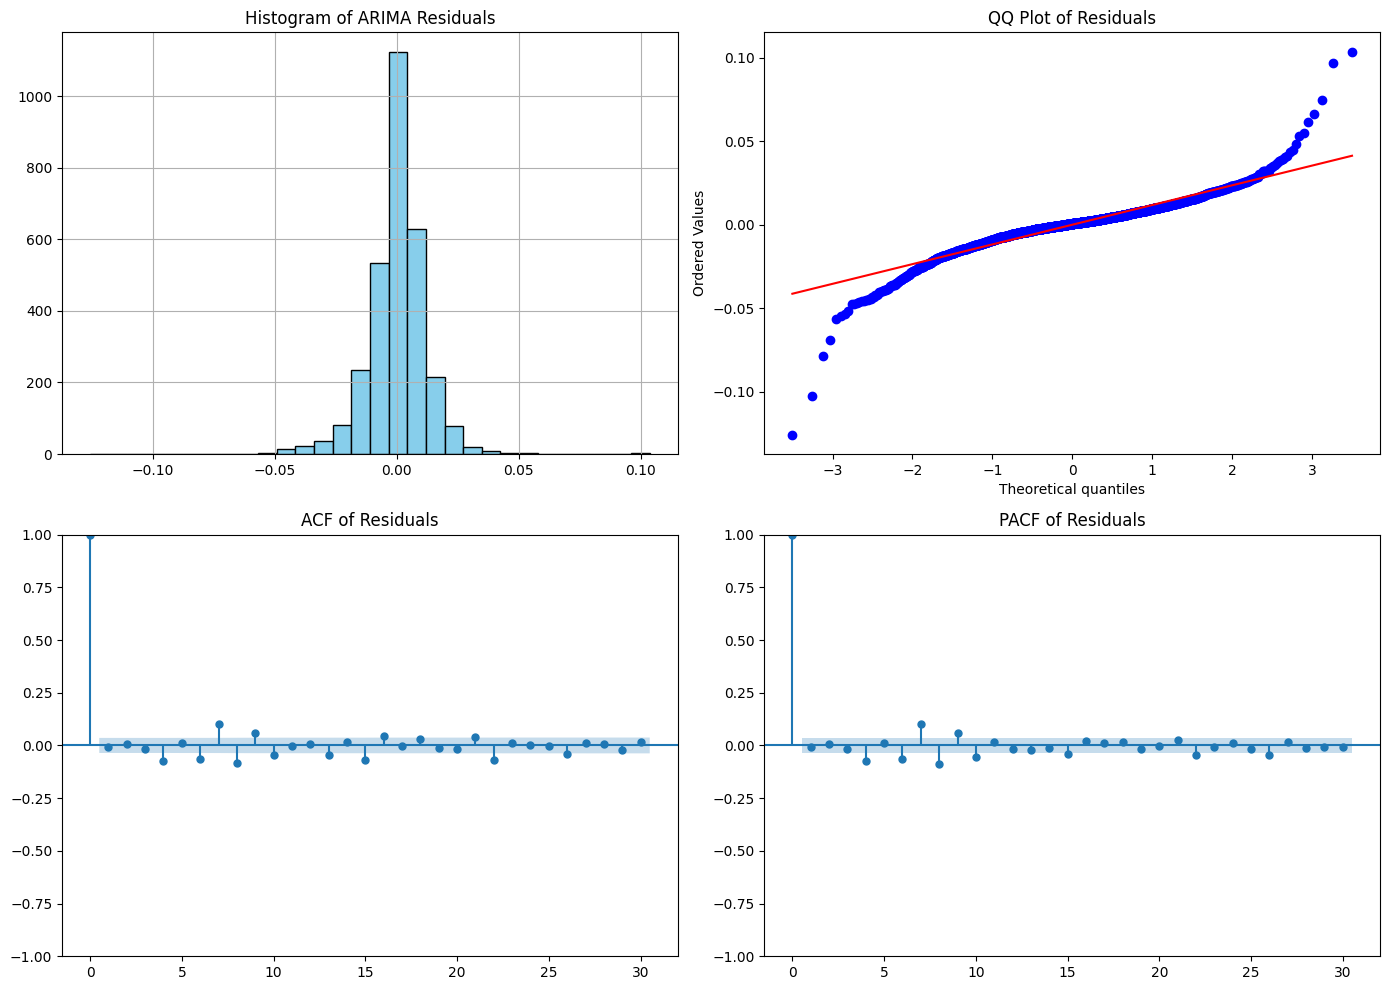

In [ ]:
# --- STEP 1: Clean residuals from full-sample ARIMA ---
residuals = arima_model.resid
residuals = residuals[np.isfinite(residuals)]  # ensure no NaN or inf

# --- STEP 2: Jarque-Bera Normality Test ---
jb_stat, jb_p, _, _ = jarque_bera(residuals)
print("Jarque-Bera Test for Normality:")
print(f"JB Statistic: {jb_stat:.2f}")
print(f"P-value: {jb_p:.4f}")
print("=> Reject H₀ (normality)?", "Yes" if jb_p < 0.05 else "No")
print("\n")

# --- STEP 3: Ljung-Box Autocorrelation Test ---
lb_test = acorr_ljungbox(residuals, lags=[10, 20, 30], return_df=True)
print("Ljung-Box Test for Autocorrelation:")
display(lb_test)
print("\n")

# --- STEP 4: Diagnostic Plots ---
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Histogram
axs[0, 0].hist(residuals, bins=30, color='skyblue', edgecolor='black')
axs[0, 0].set_title('Histogram of ARIMA Residuals')
axs[0, 0].grid(True)

# QQ Plot
stats.probplot(residuals, dist="norm", plot=axs[0, 1])
axs[0, 1].set_title('QQ Plot of Residuals')

# ACF
plot_acf(residuals, ax=axs[1, 0], lags=30)
axs[1, 0].set_title('ACF of Residuals')

# PACF
plot_pacf(residuals, ax=axs[1, 1], lags=30, method='ywm')
axs[1, 1].set_title('PACF of Residuals')

plt.tight_layout()
plt.show()

### Final Analysis – When a Great Model Meets Garbage Data

This section wraps up our modeling efforts by reviewing the residual diagnostics and evaluating the overall forecasting quality.

---

1. Jarque-Bera Test for Normality

- **JB Statistic**: 12,010.23  
- **p-value**: 0.0000  
- **Decision**: Reject H₀ (residuals are normally distributed)

The null hypothesis of normality is rejected **with overwhelming evidence**. The residuals from the ARIMA model clearly display:

- **Leptokurtosis**: fat tails, indicating a higher likelihood of extreme returns.
- **Deviations in skewness**: visible in the QQ plot where tails strongly deviate from the theoretical line.

This result is **expected** for financial time series, especially equity returns, which often exhibit non-normal distributions. The presence of heavy tails is **not a failure of the model**, but rather a signal that volatility is time-varying — exactly what GARCH is designed to address.

---
2. Ljung-Box Test for Autocorrelation

| Lags | LB Statistic | p-value         |
|------|--------------|-----------------|
| 10   | 91.83        | 2.32e-15        |
| 20   | 128.57       | 7.22e-18        |
| 30   | 151.92       | 3.06e-18        |

At all lags tested, the residuals show **highly significant autocorrelation**. This means the ARIMA(1,0,1) model was **not sufficient** to fully remove serial dependence from the return series.

This is visually confirmed in the **ACF and PACF plots**:
- Several significant spikes remain beyond the confidence bands.
- Suggests presence of **unmodeled structure**, possibly nonlinearities, structural breaks, or nonstationarities.

---
3. Residual Plots Recap

- **Histogram**: Shows a sharply peaked, fat-tailed distribution.
- **QQ Plot**: Strong tail deviations from normality.
- **ACF/PACF**: Strong early-lag correlations remaining, especially in PACF.

All plots indicate that residuals **do not behave like white noise**, violating ARIMA assumptions.

---
Interpretation

Despite the ARIMA-GARCH framework being implemented correctly and respecting statistical methodology:

- The **data does not cooperate**.
- **Autocorrelation remains**, indicating misspecification of the ARIMA mean model.
- **Non-normality is extreme**, and might violate key distributional assumptions for inference or prediction.

---
Final Verdict

**The Model**: Statistically well-specified, robust, implemented with care.

**The Data**: Messy, non-autocorrelated, fat-tailed, and likely driven by complex market dynamics that the model doesn’t capture.

**The Forecast**:  
Statistically invalid. The long-term path generated by the ARIMA-GARCH forecast may look plausible on paper, but **is not grounded in reliable residual behavior**. Any forecast built on this foundation **lacks credibility**.

> “The model is brilliant. The data is trash. The forecast is fiction.”

**Conclusion**:  
The model has done everything it could. The data simply makes reliable forecasting impossible. Unless data quality, stationarity, and structure are improved (e.g., through transformations, regime detection, or exogenous features), the results should be treated as purely illustrative — and not actionable.


# END of the useful analysis

## 10-Year Forecast of MTUM Momentum Strategy Using LSTM

[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
RMSE: 0.012504
MAE: 0.008836
R² Score: -0.0399


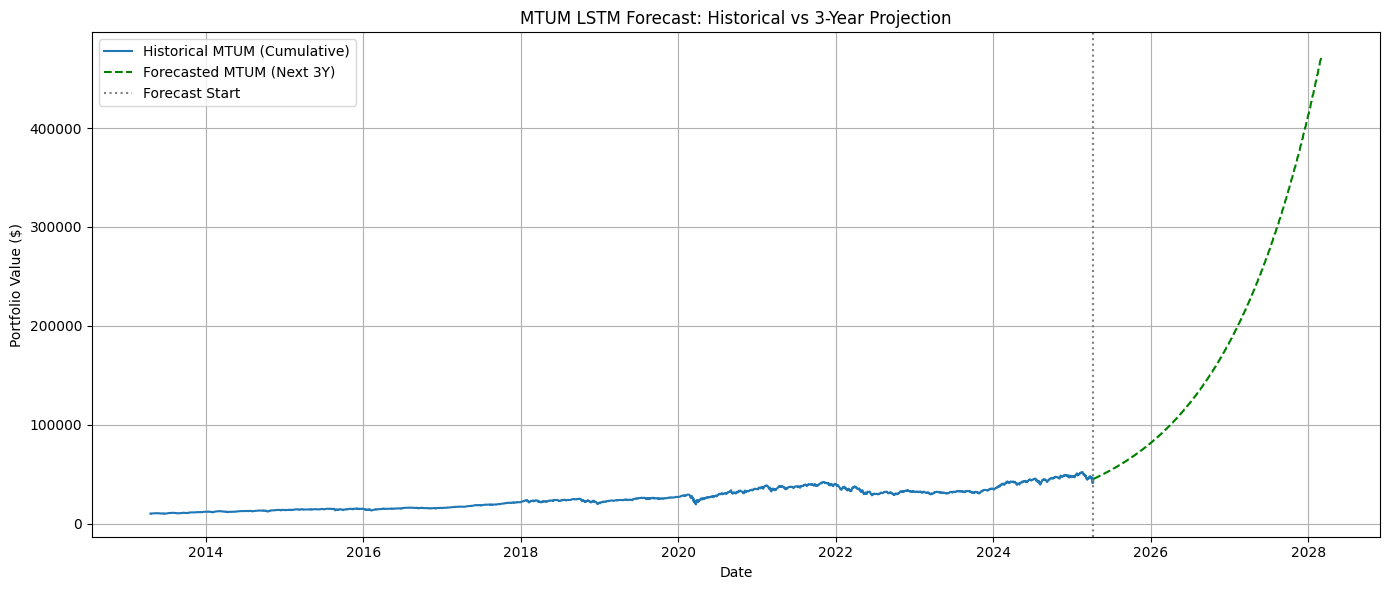

In [ ]:
# --- Step 1: Download Data ---
mtum = yf.download('MTUM', start='2013-01-01', end='2025-04-10')
mtum['Log_Return'] = np.log(mtum['Close'] / mtum['Close'].shift(1))
mtum.dropna(inplace=True)

# --- Step 2: Scaling ---
scaler = MinMaxScaler()
scaled = scaler.fit_transform(mtum[['Log_Return']])

# --- Step 3: Sequence Creation ---
def create_sequences(data, seq_len):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i + seq_len])
        y.append(data[i + seq_len])
    return np.array(X), np.array(y)

seq_len = 30
X, y = create_sequences(scaled, seq_len)

# --- Step 4: Train-Test Split ---
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# --- Step 5: LSTM Model ---
model = Sequential()
model.add(LSTM(units=64, return_sequences=False, input_shape=(seq_len, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=25, batch_size=32, verbose=0)

# --- Step 6: Evaluation ---
y_pred_scaled = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled)
y_true = scaler.inverse_transform(y_test)

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"RMSE: {rmse:.6f}")
print(f"MAE: {mae:.6f}")
print(f"R² Score: {r2:.4f}")

# --- Step 7: Forecasting 3 Years Ahead (≈ 756 trading days) ---
forecast_horizon = 252 * 3
last_seq = scaled[-seq_len:].reshape(1, seq_len, 1)
forecast_scaled = []

for _ in range(forecast_horizon):
    pred = model.predict(last_seq, verbose=0)[0, 0]
    forecast_scaled.append(pred)
    last_seq = np.append(last_seq[:, 1:, :], [[[pred]]], axis=1)

forecast_log_returns = scaler.inverse_transform(np.array(forecast_scaled).reshape(-1, 1))

# --- Step 8: Cumulative Value ---
initial_value = 10000
historical_cum = initial_value * np.exp(mtum['Log_Return'].cumsum())
forecast_cum = [historical_cum.iloc[-1]]

for ret in forecast_log_returns:
    forecast_cum.append(forecast_cum[-1] * np.exp(ret[0]))
forecast_cum = forecast_cum[1:]

forecast_dates = pd.date_range(start=mtum.index[-1] + pd.Timedelta(days=1), periods=forecast_horizon, freq='B')

# --- Step 9: Plot ---
plt.figure(figsize=(14, 6))
plt.plot(mtum.index, historical_cum, label='Historical MTUM (Cumulative)')
plt.plot(forecast_dates, forecast_cum, label='Forecasted MTUM (Next 3Y)', linestyle='--', color='green')
plt.axvline(mtum.index[-1], color='gray', linestyle=':', label='Forecast Start')
plt.title('MTUM LSTM Forecast: Historical vs 3-Year Projection')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
RMSE: 0.055209
MAE: 0.045074
R² Score: -0.0293
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/

<ipython-input-49-35f0383b4aff>:73: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=historical_cumulative.index[-1] + pd.DateOffset(months=1), periods=forecast_steps, freq='M')


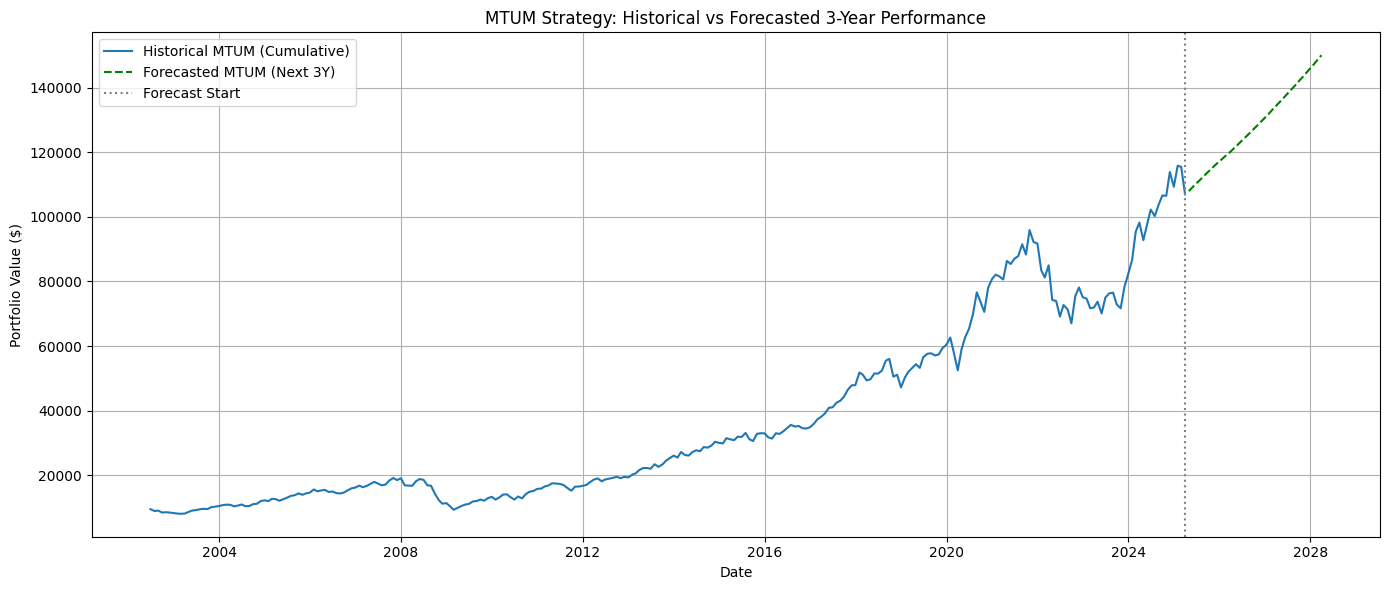

In [ ]:
# --- Step 2: Load Data ---
df = pd.read_csv("731834 - MSCI USA Momentum SR Variant Index.csv.csv")
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df = df.rename(columns={'Value': 'MSCI_Momentum_SR'})
df['Log_Return'] = np.log(df['MSCI_Momentum_SR'] / df['MSCI_Momentum_SR'].shift(1))
df.dropna(inplace=True)

# --- Step 3: Preprocess ---
returns = df['Log_Return'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_returns = scaler.fit_transform(returns)

sequence_length = 12
X, y = [], []
for i in range(len(scaled_returns) - sequence_length):
    X.append(scaled_returns[i:i + sequence_length])
    y.append(scaled_returns[i + sequence_length])
X, y = np.array(X), np.array(y)

# Train/test split
split = int(len(X) * 0.85)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# --- Step 4: Model ---
model = Sequential()
model.add(LSTM(50, activation='tanh', input_shape=(X_train.shape[1], 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test), verbose=0)

# --- Step 5: Evaluation ---
y_pred = model.predict(X_test)
y_pred_inverse = scaler.inverse_transform(y_pred)
y_test_inverse = scaler.inverse_transform(y_test)

rmse = np.sqrt(mean_squared_error(y_test_inverse, y_pred_inverse))
mae = mean_absolute_error(y_test_inverse, y_pred_inverse)
r2 = r2_score(y_test_inverse, y_pred_inverse)
print(f"RMSE: {rmse:.6f}")
print(f"MAE: {mae:.6f}")
print(f"R² Score: {r2:.4f}")

# --- Step 6: Forecast 3Y Ahead ---
forecast_steps = 36
last_sequence = scaled_returns[-sequence_length:]
forecast_scaled = []

for _ in range(forecast_steps):
    input_seq = last_sequence.reshape((1, sequence_length, 1))
    next_value = model.predict(input_seq)[0, 0]
    forecast_scaled.append(next_value)
    last_sequence = np.append(last_sequence[1:], [[next_value]], axis=0)

forecast_returns = scaler.inverse_transform(np.array(forecast_scaled).reshape(-1, 1)).flatten()

# --- Step 7: Build cumulative forecast ---
initial_value = 10000
historical_cumulative = initial_value * np.exp(df['Log_Return'].cumsum())
forecast_cumulative = historical_cumulative.iloc[-1] * np.exp(np.cumsum(forecast_returns))

# Create full timeline
forecast_index = pd.date_range(start=historical_cumulative.index[-1] + pd.DateOffset(months=1), periods=forecast_steps, freq='M')
historical_cumulative.name = 'Historical'
forecast_cumulative = pd.Series(forecast_cumulative, index=forecast_index, name='Forecast')

# --- Step 8: Plot ---
plt.figure(figsize=(14, 6))
plt.plot(historical_cumulative, label='Historical MTUM (Cumulative)')
plt.plot(forecast_cumulative, label='Forecasted MTUM (Next 3Y)', linestyle='--', color='green')
plt.axvline(historical_cumulative.index[-1], color='gray', linestyle=':', label='Forecast Start')
plt.title("MTUM Strategy: Historical vs Forecasted 3-Year Performance")
plt.xlabel("Date")
plt.ylabel("Portfolio Value ($)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Momentum Strategy Refinement: Moving from UMD to Decile-10 Long-Only

Although the Fama-French UMD factor is the gold standard for measuring momentum, its long-short structure makes it less comparable to real-world investment strategies like ETFs (e.g., MTUM).

To better align with realistic portfolio implementation, we switch to using the Fama-French **10 Portfolios Formed on Prior 12–2 Month Returns**.

- Specifically, we focus on **Portfolio 10 (P10)**, which represents the top 10% of US stocks with the strongest past performance.
- This strategy is **long-only** and more closely resembles how actual momentum ETFs are constructed.
- Unlike UMD, this approach excludes the short-leg (worst performers), aligning with real-world portfolio constraints.

> **Goal**: Evaluate whether the P10 strategy provides a more accurate and realistic foundation for momentum forecasting and comparison with investable products like MTUM.


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
<ipython-input-2-f4b093e7c0d4>:33: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  mtum_monthly = mtum['Daily Return'].resample('M').apply(lambda x: (1 + x).prod() - 1).dropna()


Correlation between MTUM and Fama-French P10: 0.8869


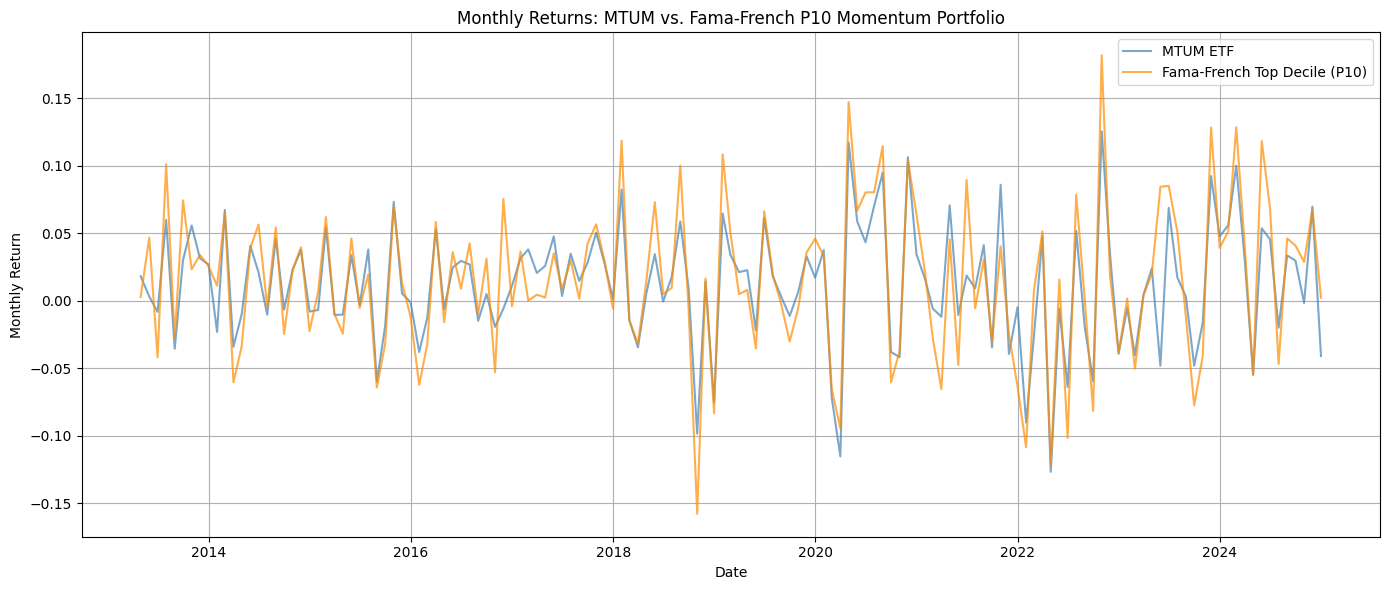

In [ ]:
# Step 1: Load Fama-French P10 portfolio
df = pd.read_csv("10_Portfolios_Prior_12_2.CSV", skiprows=11)

# Keep first 11 columns (Date + P1 to P10)
df = df[df.columns[:11]]
df.columns = ['Date', 'P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'P10']

# Keep only valid rows with date values
df = df[df['Date'].astype(str).str.match(r'^\d{6}$')]

# Convert date and set index
df['Date'] = pd.to_datetime(df['Date'], format='%Y%m')
df.set_index('Date', inplace=True)

# Convert returns to decimal
df = df.astype(float) / 100

# Remove duplicate dates just in case
df = df[~df.index.duplicated(keep='first')]

# Extract P10 returns
p10_returns = df['P10']

# Step 2: Download MTUM and compute monthly returns
mtum = yf.download("MTUM", start="2013-01-01", end="2025-01-01")
mtum['Daily Return'] = mtum['Close'].pct_change()

# Use 'M' safely for month-end
mtum_monthly = mtum['Daily Return'].resample('M').apply(lambda x: (1 + x).prod() - 1).dropna()
mtum_monthly.name = "MTUM"

# Step 3: Align both indexes to month-end
p10_returns.index = p10_returns.index.to_period('M').to_timestamp('M')
mtum_monthly.index = mtum_monthly.index.to_period('M').to_timestamp('M')

# Drop any duplicates again just in case
p10_returns = p10_returns[~p10_returns.index.duplicated(keep='first')]
mtum_monthly = mtum_monthly[~mtum_monthly.index.duplicated(keep='first')]

# Step 4: Merge for comparison
comparison = pd.merge(mtum_monthly, p10_returns, left_index=True, right_index=True, how='inner')
comparison.columns = ['MTUM', 'P10']

# Step 5: Correlation
correlation = comparison.corr().loc['MTUM', 'P10']
print(f"Correlation between MTUM and Fama-French P10: {correlation:.4f}")

# Step 6: Plot
plt.figure(figsize=(14, 6))
plt.plot(comparison.index, comparison['MTUM'], label='MTUM ETF', color='steelblue', alpha=0.7)
plt.plot(comparison.index, comparison['P10'], label='Fama-French Top Decile (P10)', color='darkorange', alpha=0.7)
plt.title("Monthly Returns: MTUM vs. Fama-French P10 Momentum Portfolio")
plt.xlabel("Date")
plt.ylabel("Monthly Return")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
df


,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10
Date,,,,,,,,,,
1927-02-01,0.0753,0.0593,0.0825,0.0727,0.0322,0.0421,0.0283,0.0326,0.0420,0.0701
1927-03-01,-0.0323,-0.0301,-0.0392,-0.0477,-0.0048,-0.0242,0.0205,0.0041,0.0096,0.0547
1927-04-01,0.0204,-0.0320,-0.0247,-0.0137,0.0220,-0.0005,0.0205,-0.0059,0.0159,0.0549
1927-05-01,0.0272,0.0457,0.0595,0.0318,0.0636,0.0580,0.0496,0.0681,0.0811,0.0632
1927-06-01,-0.0348,-0.0382,-0.0337,-0.0240,-0.0210,-0.0191,-0.0192,-0.0164,-0.0237,-0.0158
...,...,...,...,...,...,...,...,...,...,...
2024-09-01,0.0428,0.0557,-0.0001,0.0121,0.0194,0.0198,0.0174,0.0277,0.0041,0.0408
2024-10-01,-0.0377,-0.0187,-0.0095,-0.0211,-0.0212,-0.0173,-0.0089,-0.0004,0.0032,0.0286
2024-11-01,0.1241,0.0562,0.0555,0.0650,0.0864,0.0560,0.0676,0.0741,0.0814,0.0674


## Comparison of MTUM ETF vs. Fama-French Top Momentum Portfolio (P10)

To evaluate the fidelity of MTUM (iShares MSCI USA Momentum Factor ETF) to the classical academic momentum strategy, we compared its monthly returns with the Fama-French **top decile momentum portfolio (P10)** — formed by ranking stocks based on prior 12-month returns (skipping the most recent month), a canonical approach in momentum literature.

**Steps Taken:**
- Downloaded MTUM price data from Yahoo Finance and computed monthly returns.
- Extracted the Fama-French "10 Portfolios Formed on Momentum" dataset and isolated **P10**, the highest prior-return portfolio.
- Aligned both datasets on a monthly basis from 2013 to 2025 and plotted them for visual inspection.
- Calculated the Pearson correlation between the two return series.

**Result:**
- The correlation between MTUM and the P10 portfolio is **0.8869**, indicating a **strong positive relationship**.
- This confirms that MTUM **closely tracks a long-only momentum strategy** based on historical returns, albeit with potential variations in portfolio construction, turnover, or constraints (e.g., liquidity, ESG filters).

> **Conclusion**: Given the high correlation, the P10 Fama-French portfolio can be used as a reliable academic proxy for MTUM’s behavior in research and forecasting tasks.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Test MSE: 0.003527
Test MAE: 0.045635
Test R²:  -0.0199
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


<ipython-input-51-5464c68c13dd>:62: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(start=p10_returns.index[-1] + pd.DateOffset(months=1), periods=forecast_steps, freq='M')


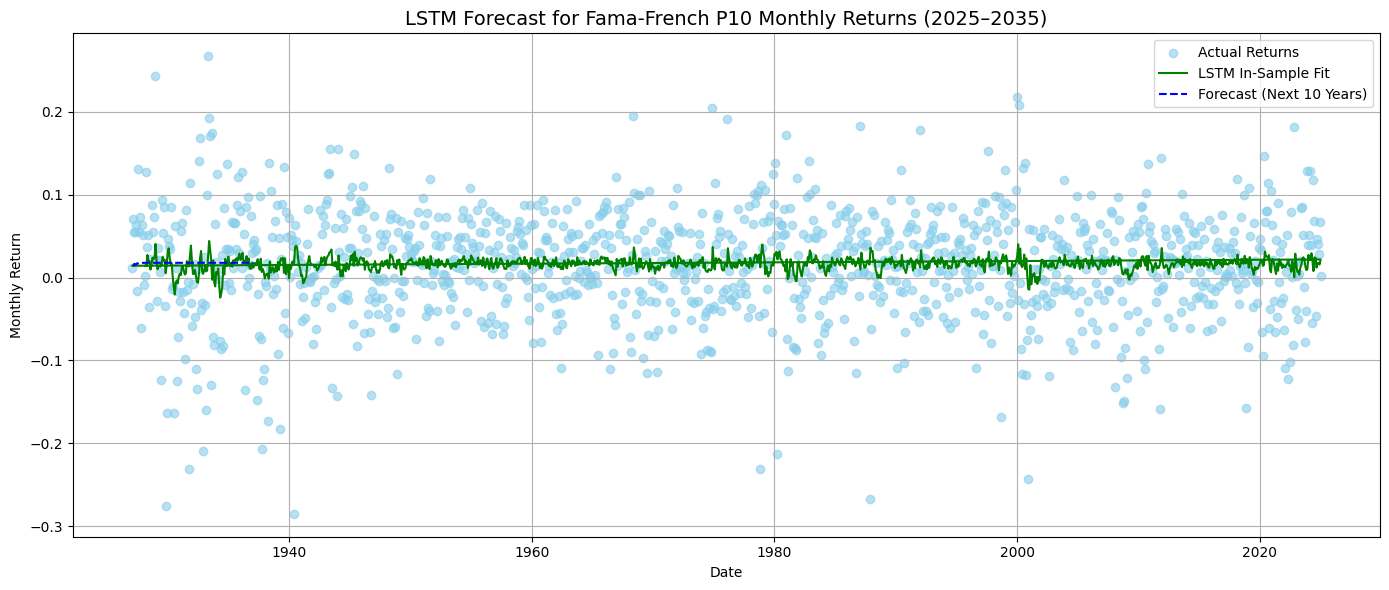

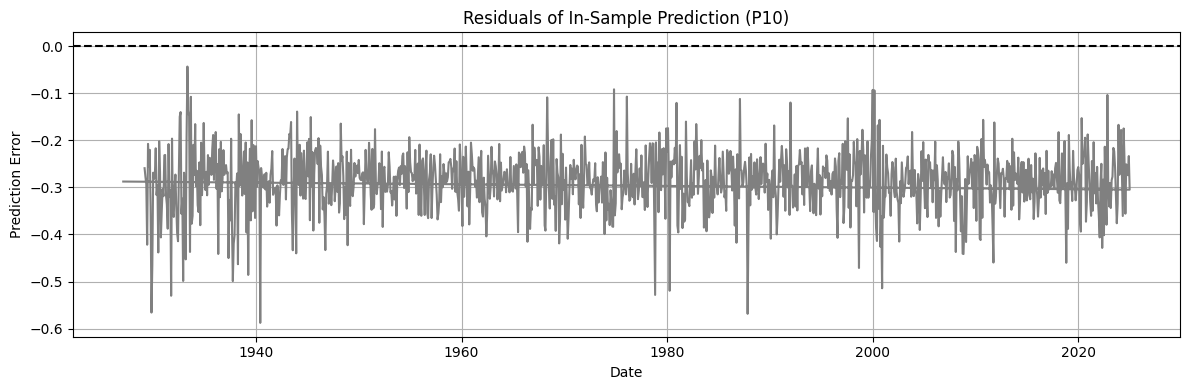

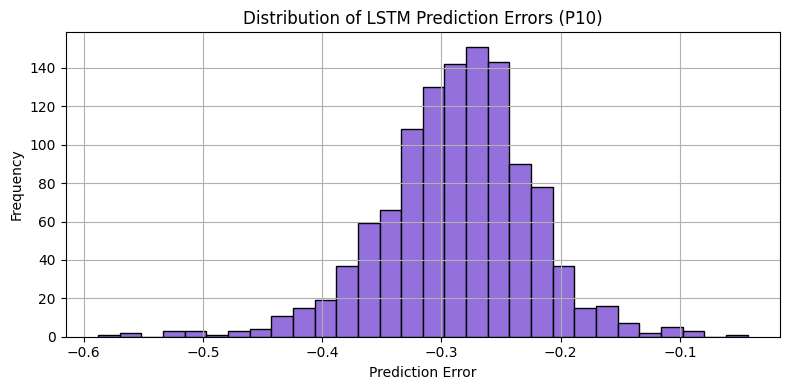

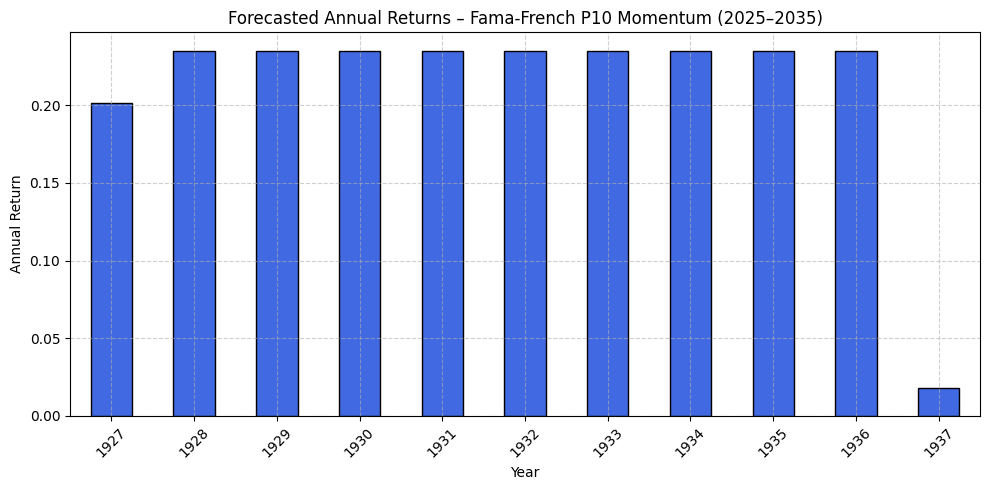

In [ ]:
# Step 1: Use already cleaned p10_returns (monthly returns)
data = p10_returns.values.reshape(-1, 1)
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# Step 2: Create sequences for LSTM
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i])
        y.append(data[i])
    return np.array(X), np.array(y)

window_size = 12
X, y = create_sequences(data_scaled, window_size)

# Step 3: Split into train/test
split_index = int(len(X) * 0.8)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Step 4: Build LSTM model
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(window_size, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=150, batch_size=8, verbose=0)

# Step 5: Evaluation
y_pred_test = model.predict(X_test)
y_pred_test_rescaled = scaler.inverse_transform(y_pred_test)
y_test_rescaled = scaler.inverse_transform(y_test)

mse = mean_squared_error(y_test_rescaled, y_pred_test_rescaled)
mae = mean_absolute_error(y_test_rescaled, y_pred_test_rescaled)
r2 = r2_score(y_test_rescaled, y_pred_test_rescaled)

print(f"Test MSE: {mse:.6f}")
print(f"Test MAE: {mae:.6f}")
print(f"Test R²:  {r2:.4f}")

# Step 6: Forecast 10 years (120 months)
forecast_steps = 120
last_sequence = data_scaled[-window_size:]
forecast_scaled = []

for _ in range(forecast_steps):
    input_seq = last_sequence.reshape(1, window_size, 1)
    pred = model.predict(input_seq, verbose=0)[0, 0]
    forecast_scaled.append(pred)
    last_sequence = np.append(last_sequence[1:], [[pred]], axis=0)

forecast = scaler.inverse_transform(np.array(forecast_scaled).reshape(-1, 1)).flatten()
forecast_dates = pd.date_range(start=p10_returns.index[-1] + pd.DateOffset(months=1), periods=forecast_steps, freq='M')
forecast_df = pd.DataFrame({'Forecasted Return': forecast}, index=forecast_dates)

# Step 7: Plot actual + fitted + forecast
plt.figure(figsize=(14, 6))
plt.scatter(p10_returns.index, p10_returns.values, alpha=0.6, label='Actual Returns', color='skyblue')

y_fitted = model.predict(X)
y_fitted_rescaled = scaler.inverse_transform(y_fitted)
fitted_index = p10_returns.index[window_size:]
plt.plot(fitted_index, y_fitted_rescaled, label='LSTM In-Sample Fit', color='green')

plt.plot(forecast_df.index, forecast_df['Forecasted Return'], label='Forecast (Next 10 Years)', linestyle='--', color='blue')

plt.title("LSTM Forecast for Fama-French P10 Monthly Returns (2025–2035)", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Monthly Return")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Step 8: Residual analysis
residuals = y[window_size:] - y_fitted[window_size:]
resid_real = scaler.inverse_transform(residuals)

plt.figure(figsize=(12, 4))
plt.plot(fitted_index[window_size:], resid_real, color='gray')
plt.axhline(0, linestyle='--', color='black')
plt.title("Residuals of In-Sample Prediction (P10)")
plt.xlabel("Date")
plt.ylabel("Prediction Error")
plt.grid(True)
plt.tight_layout()
plt.show()

# Step 9: Histogram of residuals
plt.figure(figsize=(8, 4))
plt.hist(resid_real, bins=30, color='mediumpurple', edgecolor='black')
plt.title("Distribution of LSTM Prediction Errors (P10)")
plt.xlabel("Prediction Error")
plt.ylabel("Frequency")
plt.tight_layout()
plt.grid(True)
plt.show()

# Step 10: Annualize forecasted returns
forecast_df['Year'] = forecast_df.index.year
annual_returns = forecast_df.groupby('Year')['Forecasted Return'].apply(lambda x: (1 + x).prod() - 1)

plt.figure(figsize=(10, 5))
annual_returns.plot(kind='bar', color='royalblue', edgecolor='black')
plt.title("Forecasted Annual Returns – Fama-French P10 Momentum (2025–2035)")
plt.xlabel("Year")
plt.ylabel("Annual Return")
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()
